# Setup Environment

In [ ]:
pip install shap

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from numpy.random import randint
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import io
from google.colab import files
from google.colab import drive

from sklearn.inspection import permutation_importance
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from collections import defaultdict
import shap

from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.tree import plot_tree
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score

In [ ]:
import joblib
from sklearn.metrics import make_scorer, f1_score

# Features loading & Pre Processing

## Import Data
Note: Upload files from 'TMSA files for random forests' into temporary runtime storage via left window.

Files --> Upload to session storage

In [ ]:
#Trial level data
data_original = pd.read_excel('/content/TMSA_CILT_bl_DataLong_NounAcc_only_gen_train.xlsx')
data_original.head()
np.shape(data_original)

(4620, 7)

In [ ]:
#Network Features
nets_all = pd.read_excel('/content/Network_Strength_Set_3_gen_train.xlsx')
np.shape(nets_all)

(35, 84)

In [ ]:
# Linguistic Priors
ling = pd.read_excel('/content/Linguistics_Dataset_2_generalization_train.xlsx')
ling.head(0)
np.shape(ling)

(66, 8)

In [ ]:
# Clinical Data
clin = pd.read_excel('/content/Clinical_Dataset_1_generalization_train.xlsx')
np.shape(clin)

(35, 20)

Important: Key below

In [ ]:
# combine data_original with each one, inner join
data_clin = pd.merge(data_original,clin, on=["SubjID"])
data_ling = pd.merge(data_original,ling,on=["Agent_Noun"])
data_nets_all = pd.merge(data_original,nets_all, on=["SubjID"])


In [ ]:
print(np.shape(data_clin))
print(np.shape(data_ling))
print(np.shape(data_nets_all))

(4620, 26)
(4620, 14)
(4620, 90)


In [ ]:
# Check y is the same order for all
print(np.sum(data_original[['Noun_Acc']] != data_clin[['Noun_Acc']]))
print(np.sum(data_original[['Noun_Acc']] != data_ling[['Noun_Acc']]))
print(np.sum(data_original[['Noun_Acc']] != data_nets_all[['Noun_Acc']]))

Noun_Acc    0
dtype: int64
Noun_Acc    0
dtype: int64
Noun_Acc    0
dtype: int64


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs

In [ ]:
# make y with log RT and for X dropping responses vars, irrelevant columns
y = data_original[['Noun_Acc']]
y = y.values.flatten()
len(y)

4620

In [ ]:
X_clin = data_clin.drop(['SubjID','Baseline', 'Trial', 'Card', 'Agent_Noun','Noun_Acc','Item_Type','WAB_AQ_1','WAB_AQ_2','log10_lesion_vol'], axis=1)

#changing categoricals to binary for addressing error - this goes alphabetically
le_sex = LabelEncoder()
X_clin["Sex"] = le_sex.fit_transform(X_clin['Sex'])

le_race = LabelEncoder()
X_clin["Race"] = le_race.fit_transform(X_clin['Race'])
X_clin.head()

le_eth = LabelEncoder()
X_clin["Ethnicity "] = le_eth.fit_transform(X_clin['Ethnicity '])

le_hand = LabelEncoder()
X_clin["Handed"] = le_hand.fit_transform(X_clin['Handed'])

le_class = LabelEncoder()
X_clin["Aphasia_Type_1"] = le_class.fit_transform(X_clin['Aphasia_Type_1'])

X_clin.head()


,MPO,Yrs Edu,Age,Travel solo,Sex,Race,Ethnicity,Handed,CCRSA,SS_WAB_Avg,AVC_WAB_Avg,NWF_WAB_Avg,Diff_WAB_AQ,Avg_WAB_AQ,Aphasia_Type_1,Lesion_Volume
0,98.815977,12,55.256325,1,1,4,1,2,22,12.0,9.625,8.95,0.7,76.8,1,100465
1,98.815977,12,55.256325,1,1,4,1,2,22,12.0,9.625,8.95,0.7,76.8,1,100465
2,98.815977,12,55.256325,1,1,4,1,2,22,12.0,9.625,8.95,0.7,76.8,1,100465
3,98.815977,12,55.256325,1,1,4,1,2,22,12.0,9.625,8.95,0.7,76.8,1,100465
4,98.815977,12,55.256325,1,1,4,1,2,22,12.0,9.625,8.95,0.7,76.8,1,100465


In [ ]:
np.shape(X_clin)

(4620, 16)

In [ ]:
# no missing values
X_clin.isna().sum().sum()

np.int64(0)

In [ ]:
# Only the sensible predictors - both ling + stroke here in X
# also remove columns that have details of Randomization and the Classification column directly
X_ling = data_ling.drop(['SubjID','Baseline', 'Trial', 'Agent_Noun','Noun_Acc','Item_Type', 'Card'], axis=1)

#changing categoricals to binary for addressing error - this goes alphabetically
le_freq = LabelEncoder()
X_ling["Freq_Cond"] = le_freq.fit_transform(X_ling['Freq_Cond']) #HI = 0, LO = 1

le_NA = LabelEncoder()
X_ling["NA_Cond"] = le_NA.fit_transform(X_ling['NA_Cond']) #HI = 0, LO = 1
X_ling.head()

,Freq_Cond,NA_Cond,Noun_Freq,Noun_NA,Syllables_avg (SyllaPy),Phonemes_avg (CMUDict),Morphemes
0,0,0,4.18,0.846154,3.0,8,2.0
1,0,0,2.78,0.923077,2.0,5,1.5
2,0,0,1.95,0.923077,3.0,8,3.0
3,0,0,2.28,0.730769,2.0,4,1.5
4,0,0,23.46,0.730769,1.0,3,1.0


In [ ]:
print(np.shape(X_ling))
print(X_clin.isna().sum().sum())

(4620, 7)
0


In [ ]:
# Only the sensible predictors - both networks + networks here in X
# also remove columns that have details of Randomization and the Classification column directly
X_nets_all = data_nets_all.drop(['SubjID','Baseline', 'Trial', 'Card', 'Agent_Noun','Noun_Acc','Item_Type'], axis=1)
X_nets_all.head()

,R_lateralorbitofrontal,R_parsorbitalis,R_frontalpole,R_medialorbitofrontal,R_parstriangularis,R_parsopercularis,R_rostralmiddlefrontal,R_superiorfrontal,R_caudalmiddlefrontal,R_precentral,...,L_transversetemporal,L_insula,L_thalamusproper,L_caudate,L_putamen,L_pallidum,L_accumbensarea,L_hyppocampus,L_amygdala,L_brainstem
0,3.448145,1.227379,1.222488,1.816679,1.674154,3.549238,3.676268,5.730117,4.333806,4.335973,...,0.835168,1.304104,3.169892,3.495664,1.798627,0.311372,1.764662,4.183823,0.886702,4.668745
1,3.448145,1.227379,1.222488,1.816679,1.674154,3.549238,3.676268,5.730117,4.333806,4.335973,...,0.835168,1.304104,3.169892,3.495664,1.798627,0.311372,1.764662,4.183823,0.886702,4.668745
2,3.448145,1.227379,1.222488,1.816679,1.674154,3.549238,3.676268,5.730117,4.333806,4.335973,...,0.835168,1.304104,3.169892,3.495664,1.798627,0.311372,1.764662,4.183823,0.886702,4.668745
3,3.448145,1.227379,1.222488,1.816679,1.674154,3.549238,3.676268,5.730117,4.333806,4.335973,...,0.835168,1.304104,3.169892,3.495664,1.798627,0.311372,1.764662,4.183823,0.886702,4.668745
4,3.448145,1.227379,1.222488,1.816679,1.674154,3.549238,3.676268,5.730117,4.333806,4.335973,...,0.835168,1.304104,3.169892,3.495664,1.798627,0.311372,1.764662,4.183823,0.886702,4.668745


In [ ]:
print(np.shape(X_nets_all))
print(X_nets_all.isna().sum().sum())

(4620, 83)
0


# Baseline Characteristics

Correct Answers: 1365
Incorrect Answers: 3255


<Axes: ylabel='count'>

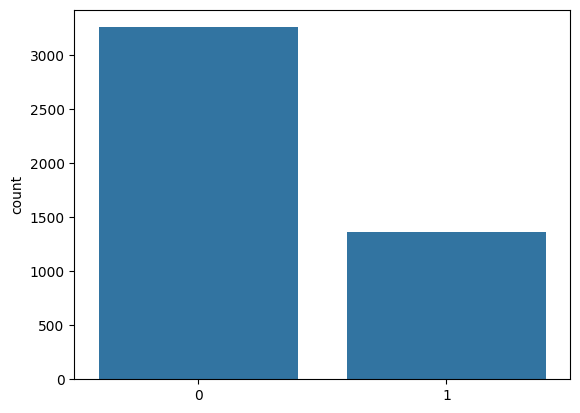

In [ ]:
print("Correct Answers:",sum(y == 1))
print("Incorrect Answers:",sum(y == 0))

sns.countplot(x = y)

In [ ]:
# To Do: Histograms & trends of all input features by dataset

Set color scheme as needed

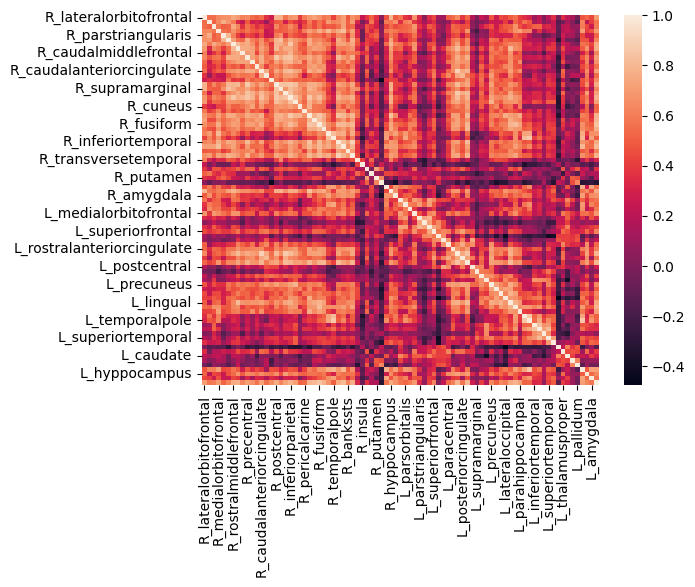

In [ ]:
# check for collinearity
# Handle non-numerical columns before calculating correlations
inputData_numeric = X_nets_all.select_dtypes(include=['number'])  # Select only numerical columns
correlation_matrix = inputData_numeric.corr()  # Calculate correlations on numerical data

# Visualize the correlation matrix using a heatmap
import seaborn as sns
sns.heatmap(correlation_matrix, annot=False)
plt.show()

# Feature Selection for Networks

Unsupervised alternative to supervised ElasticNet

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html


In [ ]:
seed = randint(1000)
# validation split
X_temp, X_val_nets_all, y_temp, y_val_nets_all = train_test_split(X_nets_all,y,train_size=0.9,random_state=seed,stratify=y)
# train test split
X_train_nets_all, X_test_nets_all, y_train_nets_all, y_test_nets_all = train_test_split(X_temp,y_temp,train_size=0.9,random_state=seed,stratify=y_temp)

In [ ]:
# Define the parameter grid for l1_ratios
param_grid = {
    'l1_ratios': [[0.6], [0.7], [0.8], [0.9]]  # Test values for ratio of l1 to l2 regularization
}

# Initialize LogisticRegression with elastic net regularization
elasticnet_nets = LogisticRegressionCV(
    cv=5,                          # Number of folds in cross-validation
    penalty='elasticnet',          # Regularization type ('elasticnet')
    multi_class='ovr',             # Multi-class strategy ('ovr' or 'multinomial')
    solver='saga',
    max_iter=5000,                 # Maximum number of iterations for convergence
    random_state=seed              # Seed for random number generator
)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=elasticnet_nets,
    param_grid=param_grid,
    cv=5,                          # Number of folds in cross-validation
    scoring='f1',                  # Evaluation metric - minority class f1 instead of accuracy - since mildly unbalanced data
    n_jobs=-1                      # Use all available cores
)

# Train the model with GridSearchCV
grid_search.fit(X_train_nets_all, y_train_nets_all)

# Get the best parameters
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Print best parameters
print("Best Parameters:")
print(f"  C: {best_estimator.C_}")
print(f"  Penalty: {best_estimator.penalty}")
print(f"  L1 Ratio: {best_params['l1_ratios'][0]}")

# Calculate training, testing accuracy to make sure it is not overfitting
print("Train Accuracy with Best ElasticNet: ", grid_search.score(X_train_nets_all, y_train_nets_all))
print("Test Accuracy with Best ElasticNet: ", grid_search.score(X_test_nets_all, y_test_nets_all))

# Make predictions on the test data
en_preds = grid_search.predict(X_test_nets_all)

# Print classification report
print("Classification Report:")
print(classification_report(y_test_nets_all, en_preds))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1917: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Best Parameters:
  C: [0.35938137]
  Penalty: elasticnet
  L1 Ratio: 0.7
Train Accuracy with Best ElasticNet:  0.3864734299516908
Test Accuracy with Best ElasticNet:  0.39106145251396646
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.93      0.83       293
           1       0.62      0.28      0.39       123

    accuracy                           0.74       416
   macro avg       0.69      0.61      0.61       416
weighted avg       0.72      0.74      0.70       416



In [ ]:
# save grid_search.cv_results_

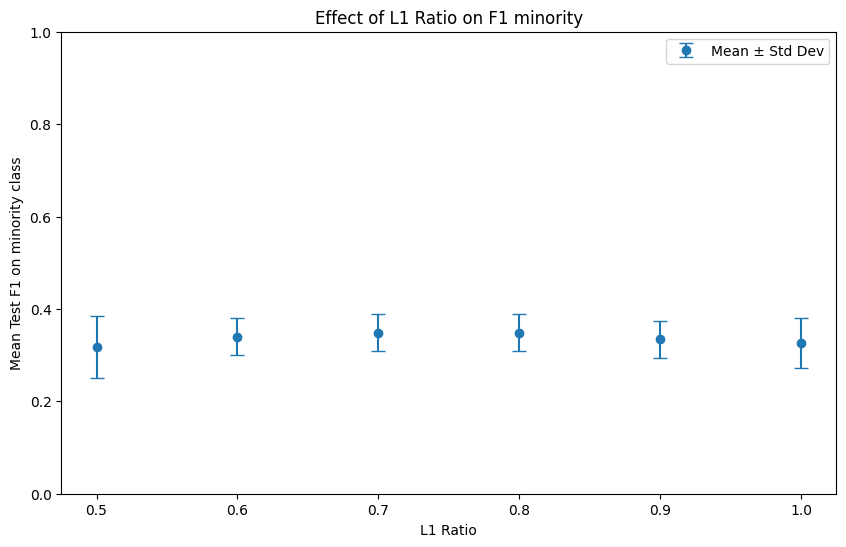

In [ ]:
# Plot accuracy vs. l1_ratios
en_results = grid_search.cv_results_
# Extract mean and standard deviation of test scores
mean_test_scores = en_results['mean_test_score']
std_test_scores = en_results['std_test_score']
l1_ratios_list = [param[0] for param in en_results['param_l1_ratios']]

plt.figure(figsize=(10, 6))
# Use errorbar to include standard deviation as error bars
plt.errorbar(l1_ratios_list, mean_test_scores, yerr=std_test_scores, fmt='o', capsize=5, label='Mean ± Std Dev')
plt.xlabel('L1 Ratio')
plt.ylabel('Mean Test F1 on minority class')
plt.title('Effect of L1 Ratio on F1 minority')
plt.xscale('linear')
plt.ylim(0, 1)
plt.legend()
plt.show()


Note that feature importances remained same across parameters

31 features, reduction of 62.65%


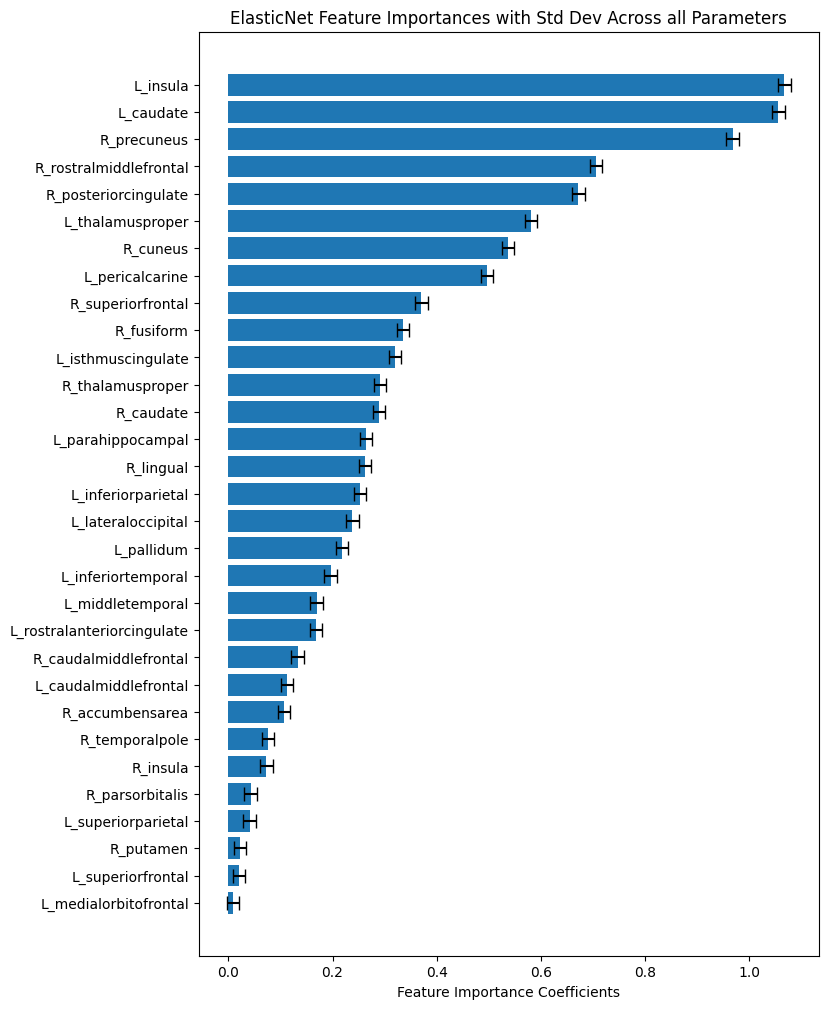

In [ ]:
best_l1_ratio = best_params['l1_ratios'][0]  # Extract the best l1_ratio

# Initialize a list to store coefficients from all parameter folds
coefficients_list = []

# Loop over the results and extract coefficients
for mean_score, params, coef in zip(en_results['mean_test_score'], en_results['params'], en_results['split0_test_score']):
    # Check if the current fold uses the best l1_ratio
    coefficients_list.append(coef.flatten())

# Convert the list of coefficients into a numpy array
coefficients_array = np.array(coefficients_list)

# Compute the standard deviation of coefficients across folds (axis=0 is across all features)
coef_std_dev = np.std(coefficients_array, axis=0)

# Now extract the mean (importance) of the coefficients for the best estimator
mean_coefficients = np.abs(best_estimator.coef_.flatten())

# Create a DataFrame to include feature importances and their standard deviations
feature_importances_with_std = pd.DataFrame({
    'importance': mean_coefficients,
    'std_dev': coef_std_dev
}, index=X_train_nets_all.columns)

# Sort the features by importance and plot
n_selected_features = (feature_importances_with_std['importance'] > 0).sum()
print(f'{n_selected_features:d} features, reduction of {(1 - n_selected_features / len(feature_importances_with_std)) * 100:2.2f}%')

# Sort features by importance
sorted_features = feature_importances_with_std.sort_values('importance').tail(n_selected_features)

# Plotting with error bars
plt.figure(figsize=(8, 12))
plt.barh(sorted_features.index, sorted_features['importance'], xerr=sorted_features['std_dev'], capsize=5)
plt.xlabel('Feature Importance Coefficients')
plt.title('ElasticNet Feature Importances with Std Dev Across all Parameters')
plt.show()

In [ ]:
# Save the feature importances and coefficients to a CSV file
output_filename = 'EN_feature_selection_importances_with_std.csv'
feature_importances_with_std.to_csv(output_filename)

In [ ]:
# Create a new dataset with only the selected features
selected_features = feature_importances[feature_importances > 0].index  # Columns with non-zero importance

data_nets_sel = data_nets_all[selected_features]
X_nets_sel = X_nets_all[selected_features]

# Verify the new datasets
print("Shape of X_nets_sel:", X_nets_sel.shape)
print("Shape of data_nets_sel:", data_nets_sel.shape)


Shape of X_nets_sel: (4620, 31)
Shape of data_nets_sel: (4620, 31)


# Create set of selected networks & all3 sets

In [ ]:
#Import Selected Network Features (so that don't have to run elastic net each time)
nets_sel = pd.read_excel('/content/Selected_Network_Strength_Set_3_gen_train.xlsx')
np.shape(nets_sel)

(35, 29)

In [ ]:
data_nets_sel = pd.merge(data_original, nets_sel, on=["SubjID"])
np.shape(data_nets_sel)

(4620, 35)

In [ ]:
# Only the sensible predictors - both networks + networks here in X
# also remove columns that have details of Randomization and the Classification column directly
X_nets_sel = data_nets_sel.drop(['SubjID','Baseline', 'Trial', 'Card', 'Agent_Noun','Noun_Acc','Item_Type'], axis=1)
X_nets_sel.head()

,R_parsorbitalis,R_rostralmiddlefrontal,R_superiorfrontal,R_posteriorcingulate,R_precuneus,R_cuneus,R_lingual,R_thalamusproper,R_putamen,L_medialorbitofrontal,...,L_caudate,R_fusiform,R_caudate,L_parahippocampal,L_inferiorparietal,R_caudalmiddlefrontal,R_accumbensarea,R_temporalpole,R_insula,L_superiorparietal
0,1.227379,3.676268,5.730117,4.329494,5.635827,1.263096,3.228681,3.852784,2.453537,2.805267,...,3.495664,3.052521,8.642509,1.458115,3.100879,4.333806,1.393523,0.83136,2.667342,2.387779
1,1.227379,3.676268,5.730117,4.329494,5.635827,1.263096,3.228681,3.852784,2.453537,2.805267,...,3.495664,3.052521,8.642509,1.458115,3.100879,4.333806,1.393523,0.83136,2.667342,2.387779
2,1.227379,3.676268,5.730117,4.329494,5.635827,1.263096,3.228681,3.852784,2.453537,2.805267,...,3.495664,3.052521,8.642509,1.458115,3.100879,4.333806,1.393523,0.83136,2.667342,2.387779
3,1.227379,3.676268,5.730117,4.329494,5.635827,1.263096,3.228681,3.852784,2.453537,2.805267,...,3.495664,3.052521,8.642509,1.458115,3.100879,4.333806,1.393523,0.83136,2.667342,2.387779
4,1.227379,3.676268,5.730117,4.329494,5.635827,1.263096,3.228681,3.852784,2.453537,2.805267,...,3.495664,3.052521,8.642509,1.458115,3.100879,4.333806,1.393523,0.83136,2.667342,2.387779


In [ ]:
print(np.shape(X_nets_sel))
print(X_nets_sel.isna().sum().sum())

(4620, 28)
0


In [ ]:
# make combo sets
data_clin_ling = pd.merge(data_clin, ling, on=["Agent_Noun"])
data_all3 = pd.merge(data_clin_ling, nets_all, on=["SubjID"])
data_all3_sel = pd.merge(data_clin_ling, nets_sel, on=["SubjID"])

In [ ]:
print(np.shape(data_clin_ling))
print(np.shape(data_all3))
print(np.shape(data_all3_sel))

(4620, 33)
(4620, 116)
(4620, 61)


In [ ]:
# Check y is the same order for all
print(np.sum(data_original[['Noun_Acc']] != data_clin_ling[['Noun_Acc']]))
print(np.sum(data_original[['Noun_Acc']] != data_all3[['Noun_Acc']]))
print(np.sum(data_original[['Noun_Acc']] != data_all3_sel[['Noun_Acc']]))

Noun_Acc    0
dtype: int64
Noun_Acc    0
dtype: int64
Noun_Acc    0
dtype: int64


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [ ]:
X_clin_ling = data_clin_ling.drop(['SubjID','Baseline', 'Trial', 'Card', 'Agent_Noun','Noun_Acc','Item_Type','WAB_AQ_1','WAB_AQ_2','log10_lesion_vol', 'Card'], axis=1)

#changing categoricals to binary for addressing error - this goes alphabetically
X_clin_ling["Sex"] = le_sex.fit_transform(X_clin_ling['Sex'])

X_clin_ling["Race"] = le_race.fit_transform(X_clin_ling['Race'])

X_clin_ling["Ethnicity "] = le_eth.fit_transform(X_clin_ling['Ethnicity '])

X_clin_ling["Handed"] = le_hand.fit_transform(X_clin_ling['Handed'])

X_clin_ling["Aphasia_Type_1"] = le_class.fit_transform(X_clin_ling['Aphasia_Type_1'])

X_clin_ling["Freq_Cond"] = le_freq.fit_transform(X_clin_ling['Freq_Cond']) #HI = 0, LO = 1

X_clin_ling["NA_Cond"] = le_NA.fit_transform(X_clin_ling['NA_Cond']) #HI = 0, LO = 1

X_clin_ling.head()


,MPO,Yrs Edu,Age,Travel solo,Sex,Race,Ethnicity,Handed,CCRSA,SS_WAB_Avg,...,Avg_WAB_AQ,Aphasia_Type_1,Lesion_Volume,Freq_Cond,NA_Cond,Noun_Freq,Noun_NA,Syllables_avg (SyllaPy),Phonemes_avg (CMUDict),Morphemes
0,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,76.8,1,100465,0,0,4.18,0.846154,3.0,8,2.0
1,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,76.8,1,100465,0,0,2.78,0.923077,2.0,5,1.5
2,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,76.8,1,100465,0,0,1.95,0.923077,3.0,8,3.0
3,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,76.8,1,100465,0,0,2.28,0.730769,2.0,4,1.5
4,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,76.8,1,100465,0,0,23.46,0.730769,1.0,3,1.0


In [ ]:
print(np.shape(X_clin_ling))
print(X_clin_ling.isna().sum().sum())

(4620, 23)
0


In [ ]:
X_all3 = data_all3.drop(['SubjID','Baseline', 'Trial', 'Card', 'Agent_Noun','Noun_Acc','Item_Type','WAB_AQ_1','WAB_AQ_2','log10_lesion_vol', 'Card'], axis=1)

#changing categoricals to binary for addressing error - this goes alphabetically
X_all3["Sex"] = le_sex.fit_transform(X_all3['Sex'])

X_all3["Race"] = le_race.fit_transform(X_all3['Race'])

X_all3["Ethnicity "] = le_eth.fit_transform(X_all3['Ethnicity '])

X_all3["Handed"] = le_hand.fit_transform(X_all3['Handed'])

X_all3["Aphasia_Type_1"] = le_class.fit_transform(X_all3['Aphasia_Type_1'])

X_all3["Freq_Cond"] = le_freq.fit_transform(X_all3['Freq_Cond']) #HI = 0, LO = 1

X_all3["NA_Cond"] = le_NA.fit_transform(X_all3['NA_Cond']) #HI = 0, LO = 1

X_all3.head()

,MPO,Yrs Edu,Age,Travel solo,Sex,Race,Ethnicity,Handed,CCRSA,SS_WAB_Avg,...,L_transversetemporal,L_insula,L_thalamusproper,L_caudate,L_putamen,L_pallidum,L_accumbensarea,L_hyppocampus,L_amygdala,L_brainstem
0,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,0.835168,1.304104,3.169892,3.495664,1.798627,0.311372,1.764662,4.183823,0.886702,4.668745
1,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,0.835168,1.304104,3.169892,3.495664,1.798627,0.311372,1.764662,4.183823,0.886702,4.668745
2,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,0.835168,1.304104,3.169892,3.495664,1.798627,0.311372,1.764662,4.183823,0.886702,4.668745
3,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,0.835168,1.304104,3.169892,3.495664,1.798627,0.311372,1.764662,4.183823,0.886702,4.668745
4,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,0.835168,1.304104,3.169892,3.495664,1.798627,0.311372,1.764662,4.183823,0.886702,4.668745


In [ ]:
print(np.shape(X_all3))
print(X_all3.isna().sum().sum())

(4620, 106)
0


In [ ]:
X_all3_sel = data_all3_sel.drop(['SubjID','Baseline', 'Trial', 'Card', 'Agent_Noun','Noun_Acc','Item_Type','WAB_AQ_1','WAB_AQ_2','log10_lesion_vol', 'Card'], axis=1)

#changing categoricals to binary for addressing error - this goes alphabetically
X_all3_sel["Sex"] = le_sex.fit_transform(X_all3['Sex'])

X_all3_sel["Race"] = le_race.fit_transform(X_all3['Race'])

X_all3_sel["Ethnicity "] = le_eth.fit_transform(X_all3['Ethnicity '])

X_all3_sel["Handed"] = le_hand.fit_transform(X_all3['Handed'])

X_all3_sel["Aphasia_Type_1"] = le_class.fit_transform(X_all3['Aphasia_Type_1'])

X_all3_sel["Freq_Cond"] = le_freq.fit_transform(X_all3['Freq_Cond']) #HI = 0, LO = 1

X_all3_sel["NA_Cond"] = le_NA.fit_transform(X_all3['NA_Cond']) #HI = 0, LO = 1

X_all3_sel.head()

,MPO,Yrs Edu,Age,Travel solo,Sex,Race,Ethnicity,Handed,CCRSA,SS_WAB_Avg,...,L_caudate,R_fusiform,R_caudate,L_parahippocampal,L_inferiorparietal,R_caudalmiddlefrontal,R_accumbensarea,R_temporalpole,R_insula,L_superiorparietal
0,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,3.495664,3.052521,8.642509,1.458115,3.100879,4.333806,1.393523,0.83136,2.667342,2.387779
1,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,3.495664,3.052521,8.642509,1.458115,3.100879,4.333806,1.393523,0.83136,2.667342,2.387779
2,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,3.495664,3.052521,8.642509,1.458115,3.100879,4.333806,1.393523,0.83136,2.667342,2.387779
3,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,3.495664,3.052521,8.642509,1.458115,3.100879,4.333806,1.393523,0.83136,2.667342,2.387779
4,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,3.495664,3.052521,8.642509,1.458115,3.100879,4.333806,1.393523,0.83136,2.667342,2.387779


In [ ]:
print(np.shape(X_all3_sel))
print(X_all3_sel.isna().sum().sum())

(4620, 51)
0


# Combination sets of 2

In [ ]:
# make combo sets
data_clin_ling = pd.merge(data_clin, ling, on=["Agent_Noun"])
data_clin_nets_sel = pd.merge(data_clin, nets_all, on=["SubjID"])
data_ling_nets_sel = pd.merge(data_ling, nets_sel, on=["SubjID"])

In [ ]:
print(np.shape(data_clin_ling))
print(np.shape(data_clin_nets_sel))
print(np.shape(data_ling_nets_sel))

(4620, 33)
(4620, 109)
(4620, 42)


In [ ]:
# Check y is the same order for all
print(np.sum(data_original[['Noun_Acc']] != data_clin_ling[['Noun_Acc']]))
print(np.sum(data_original[['Noun_Acc']] != data_clin_nets_sel[['Noun_Acc']]))
print(np.sum(data_original[['Noun_Acc']] != data_ling_nets_sel[['Noun_Acc']]))

Noun_Acc    0
dtype: int64
Noun_Acc    0
dtype: int64
Noun_Acc    0
dtype: int64


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [ ]:
X_clin_ling = data_clin_ling.drop(['SubjID','Baseline', 'Trial', 'Card', 'Agent_Noun','Noun_Acc','Item_Type','WAB_AQ_1','WAB_AQ_2','log10_lesion_vol', 'Card'], axis=1)

#changing categoricals to binary for addressing error - this goes alphabetically
X_clin_ling["Sex"] = le_sex.fit_transform(X_clin_ling['Sex'])

X_clin_ling["Race"] = le_race.fit_transform(X_clin_ling['Race'])

X_clin_ling["Ethnicity "] = le_eth.fit_transform(X_clin_ling['Ethnicity '])

X_clin_ling["Handed"] = le_hand.fit_transform(X_clin_ling['Handed'])

X_clin_ling["Aphasia_Type_1"] = le_class.fit_transform(X_clin_ling['Aphasia_Type_1'])

X_clin_ling["Freq_Cond"] = le_freq.fit_transform(X_clin_ling['Freq_Cond']) #HI = 0, LO = 1

X_clin_ling["NA_Cond"] = le_NA.fit_transform(X_clin_ling['NA_Cond']) #HI = 0, LO = 1

X_clin_ling.head()


,MPO,Yrs Edu,Age,Travel solo,Sex,Race,Ethnicity,Handed,CCRSA,SS_WAB_Avg,...,Avg_WAB_AQ,Aphasia_Type_1,Lesion_Volume,Freq_Cond,NA_Cond,Noun_Freq,Noun_NA,Syllables_avg (SyllaPy),Phonemes_avg (CMUDict),Morphemes
0,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,76.8,1,100465,0,0,4.18,0.846154,3.0,8,2.0
1,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,76.8,1,100465,0,0,2.78,0.923077,2.0,5,1.5
2,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,76.8,1,100465,0,0,1.95,0.923077,3.0,8,3.0
3,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,76.8,1,100465,0,0,2.28,0.730769,2.0,4,1.5
4,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,76.8,1,100465,0,0,23.46,0.730769,1.0,3,1.0


In [ ]:
print(np.shape(X_clin_ling))
print(X_clin_ling.isna().sum().sum())

(4620, 23)
0


In [ ]:
X_clin_nets_sel= data_clin_nets_sel.drop(['SubjID','Baseline', 'Trial', 'Card', 'Agent_Noun','Noun_Acc','Item_Type','WAB_AQ_1','WAB_AQ_2','log10_lesion_vol', 'Card'], axis=1)

#changing categoricals to binary for addressing error - this goes alphabetically
X_clin_nets_sel["Sex"] = le_sex.fit_transform(X_clin_nets_sel['Sex'])

X_clin_nets_sel["Race"] = le_race.fit_transform(X_clin_nets_sel['Race'])

X_clin_nets_sel["Ethnicity "] = le_eth.fit_transform(X_clin_nets_sel['Ethnicity '])

X_clin_nets_sel["Handed"] = le_hand.fit_transform(X_clin_nets_sel['Handed'])

X_clin_nets_sel["Aphasia_Type_1"] = le_class.fit_transform(X_clin_nets_sel['Aphasia_Type_1'])

X_clin_nets_sel.head()

,MPO,Yrs Edu,Age,Travel solo,Sex,Race,Ethnicity,Handed,CCRSA,SS_WAB_Avg,...,L_transversetemporal,L_insula,L_thalamusproper,L_caudate,L_putamen,L_pallidum,L_accumbensarea,L_hyppocampus,L_amygdala,L_brainstem
0,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,0.835168,1.304104,3.169892,3.495664,1.798627,0.311372,1.764662,4.183823,0.886702,4.668745
1,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,0.835168,1.304104,3.169892,3.495664,1.798627,0.311372,1.764662,4.183823,0.886702,4.668745
2,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,0.835168,1.304104,3.169892,3.495664,1.798627,0.311372,1.764662,4.183823,0.886702,4.668745
3,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,0.835168,1.304104,3.169892,3.495664,1.798627,0.311372,1.764662,4.183823,0.886702,4.668745
4,98.815977,12,55.256325,1,1,4,1,2,22,12.0,...,0.835168,1.304104,3.169892,3.495664,1.798627,0.311372,1.764662,4.183823,0.886702,4.668745


In [ ]:
print(np.shape(X_clin_nets_sel))
print(X_clin_nets_sel.isna().sum().sum())

(4620, 99)
0


In [ ]:
X_ling_nets_sel = data_ling_nets_sel.drop(['SubjID','Baseline', 'Trial', 'Card', 'Agent_Noun','Noun_Acc','Item_Type', 'Card'], axis=1)

#changing categoricals to binary for addressing error - this goes alphabetically
X_ling_nets_sel["Freq_Cond"] = le_freq.fit_transform(X_ling_nets_sel['Freq_Cond']) #HI = 0, LO = 1

X_ling_nets_sel["NA_Cond"] = le_NA.fit_transform(X_ling_nets_sel['NA_Cond']) #HI = 0, LO = 1

X_ling_nets_sel.head()

,Freq_Cond,NA_Cond,Noun_Freq,Noun_NA,Syllables_avg (SyllaPy),Phonemes_avg (CMUDict),Morphemes,R_parsorbitalis,R_rostralmiddlefrontal,R_superiorfrontal,...,L_caudate,R_fusiform,R_caudate,L_parahippocampal,L_inferiorparietal,R_caudalmiddlefrontal,R_accumbensarea,R_temporalpole,R_insula,L_superiorparietal
0,0,0,4.18,0.846154,3.0,8,2.0,1.227379,3.676268,5.730117,...,3.495664,3.052521,8.642509,1.458115,3.100879,4.333806,1.393523,0.83136,2.667342,2.387779
1,0,0,2.78,0.923077,2.0,5,1.5,1.227379,3.676268,5.730117,...,3.495664,3.052521,8.642509,1.458115,3.100879,4.333806,1.393523,0.83136,2.667342,2.387779
2,0,0,1.95,0.923077,3.0,8,3.0,1.227379,3.676268,5.730117,...,3.495664,3.052521,8.642509,1.458115,3.100879,4.333806,1.393523,0.83136,2.667342,2.387779
3,0,0,2.28,0.730769,2.0,4,1.5,1.227379,3.676268,5.730117,...,3.495664,3.052521,8.642509,1.458115,3.100879,4.333806,1.393523,0.83136,2.667342,2.387779
4,0,0,23.46,0.730769,1.0,3,1.0,1.227379,3.676268,5.730117,...,3.495664,3.052521,8.642509,1.458115,3.100879,4.333806,1.393523,0.83136,2.667342,2.387779


In [ ]:
print(np.shape(X_ling_nets_sel))
print(X_ling_nets_sel.isna().sum().sum())

(4620, 35)
0


# Optimized RF models for each individual dataset

In [ ]:
# same for all models
param_dist = {
    'n_estimators': [50, 75, 100, 125, 150],
    'max_depth': [10, 15, 20],
    'max_features': ['sqrt','log2'],
    'min_samples_split': [0.0025, 0.005, 0.0075],
    'min_samples_leaf': [0.001, 0.0015, 0.002]
}

## Clinical data only

Validation set split - rename these to be unique val and test train sets by dataset

In [ ]:
seed = randint(10000)
# validation split
X_temp_clin, X_val_clin, y_temp_clin, y_val_clin = train_test_split(X_clin,y,train_size=0.9,random_state=seed,stratify=y)
# train test split
X_train_clin, X_test_clin, y_train_clin, y_test_clin = train_test_split(X_temp_clin,y_temp_clin,train_size=0.9,random_state=seed,stratify=y_temp_clin)

In [ ]:
# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=seed)

# Initialize RandomizedSearchCV
random_search_clin = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=200,   # Number of parameter settings to sample
    cv=5,        # Number of cross-validation folds - stratified by default
    verbose=2,   # Controls the verbosity
    random_state=seed,
    n_jobs=-1    # Use all available cores
)

# Fit RandomizedSearchCV
random_search_clin.fit(X_train_clin, y_train_clin)

# Get the best model
best_rf = random_search_clin.best_estimator_


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


Get the mean and std from this - output the full list & save or note down

In [ ]:
# Access the cv_results_ dictionary
clin_rf_results = random_search_clin.cv_results_

# Extract the relevant parameters and scores
param_results = pd.DataFrame(clin_rf_results['params'])  # DataFrame of parameters
param_results['mean_test_score'] = clin_rf_results['mean_test_score']  # mean test scores for each set of parameters
param_results['std_test_score'] = clin_rf_results['std_test_score']   # std for 5 folds across each set of params

# Save to CSV
param_results.to_csv('clin_only_rf_results.csv', index=False)


In [ ]:
# Print the parameters of the best estimator
print("Best estimator parameters:")
print(random_search_clin.best_estimator_.get_params())

Best estimator parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.001, 'min_samples_split': 0.005, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 4676, 'verbose': 0, 'warm_start': False}


In [ ]:
best_rf_clin = random_search_clin.best_estimator_
# Evaluate on training data
train_acc = best_rf_clin.score(X_train_clin, y_train_clin)
print(f"Train Accuracy: {train_acc:.4f}")

# Evaluate on test data
test_acc = best_rf_clin.score(X_test_clin, y_test_clin)
print(f"Test Accuracy: {test_acc:.4f}")

# Predict on test data
preds = best_rf_clin.predict(X_test_clin)
print(classification_report(y_test_clin, preds))


Train Accuracy: 0.7298
Test Accuracy: 0.7356
              precision    recall  f1-score   support

           0       0.75      0.93      0.83       291
           1       0.64      0.27      0.38       125

    accuracy                           0.74       416
   macro avg       0.70      0.60      0.61       416
weighted avg       0.72      0.74      0.70       416



[[0.9347079 0.0652921]
 [0.728     0.272    ]]


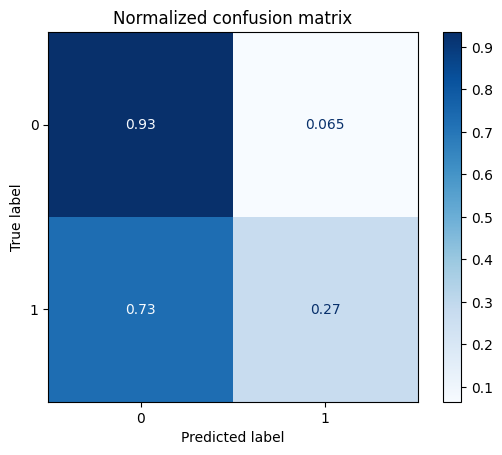

In [ ]:
# Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(best_rf,X_test_clin,y_test_clin,display_labels=np.unique(y_test_clin),cmap=plt.cm.Blues,normalize="true")
disp.ax_.set_title("Normalized confusion matrix")
print(disp.confusion_matrix)
plt.show()

In [ ]:
y_roc = pd.DataFrame(y)
type(y_roc)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

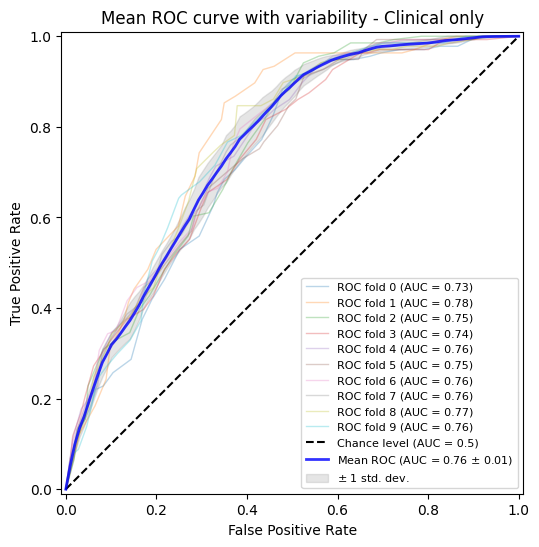

In [ ]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X_clin, y_roc)):
    best_rf_clin.fit(X_clin.iloc[train], y_roc.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        best_rf_clin,
        X_clin.iloc[test],
        y_roc.iloc[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability - Clinical only",
)
ax.legend(loc="lower right", prop={'size': 8})
plt.show()


In [ ]:
best_rf_clin = random_search_clin.best_estimator_

# Save the best Random Forest model to a file
joblib.dump(best_rf_clin, 'best_rf_clin.pkl')

['best_rf_clin.pkl']

In [ ]:
# Load the saved model
best_rf_clin = joblib.load('best_rf_clin.pkl')
# Verify
print(best_rf_clin)


RandomForestClassifier(max_depth=15, max_features='log2',
                       min_samples_leaf=0.001, min_samples_split=0.005,
                       n_estimators=50, random_state=4676)


## Linguistic Data

In [ ]:
seed = randint(10000)
# validation split
X_temp_ling, X_val_ling, y_temp_ling, y_val_ling = train_test_split(X_ling,y,train_size=0.9,random_state=seed,stratify=y)
# train test split
X_train_ling, X_test_ling, y_train_ling, y_test_ling = train_test_split(X_temp_ling,y_temp_ling,train_size=0.9,random_state=seed,stratify=y_temp_ling)

In [ ]:
# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=seed)

# Initialize RandomizedSearchCV
random_search_ling = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=200,   # Number of parameter settings to sample
    cv=5,        # Number of cross-validation folds - stratified by default
    verbose=2,   # Controls the verbosity
    random_state=seed,
    n_jobs=-1    # Use all available cores
)

# Fit RandomizedSearchCV
random_search_ling.fit(X_train_ling, y_train_ling)

# Get the best model
best_rf_ling = random_search_ling.best_estimator_


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


Get the mean and std from this - output the full list & save or note down

In [ ]:
# Access the cv_results_ dictionary
ling_rf_results = random_search_ling.cv_results_

# Extract the relevant parameters and scores
param_results = pd.DataFrame(ling_rf_results['params'])  # DataFrame of parameters
param_results['mean_test_score'] = ling_rf_results['mean_test_score']  # mean test scores for each set of parameters
param_results['std_test_score'] = ling_rf_results['std_test_score']   # std for 5 folds across each set of params

# Save to CSV
param_results.to_csv('ling_only_rf_results.csv', index=False)


In [ ]:
# Print the parameters of the best estimator
print("Best estimator parameters:")
print(random_search_ling.best_estimator_.get_params())

Best estimator parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.001, 'min_samples_split': 0.005, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 592, 'verbose': 0, 'warm_start': False}


In [ ]:
# Evaluate on training data
train_acc = best_rf_ling.score(X_train_ling, y_train_ling)
print(f"Train Accuracy: {train_acc:.4f}")

# Evaluate on test data
test_acc = best_rf_ling.score(X_test_ling, y_test_ling)
print(f"Test Accuracy: {test_acc:.4f}")

# Predict on test data
preds = best_rf_ling.predict(X_test_ling)
print(classification_report(y_test_ling, preds))


Train Accuracy: 0.7424
Test Accuracy: 0.7043
              precision    recall  f1-score   support

           0       0.75      0.87      0.81       293
           1       0.50      0.32      0.39       123

    accuracy                           0.70       416
   macro avg       0.63      0.59      0.60       416
weighted avg       0.68      0.70      0.68       416



[[0.8668942  0.1331058 ]
 [0.68292683 0.31707317]]


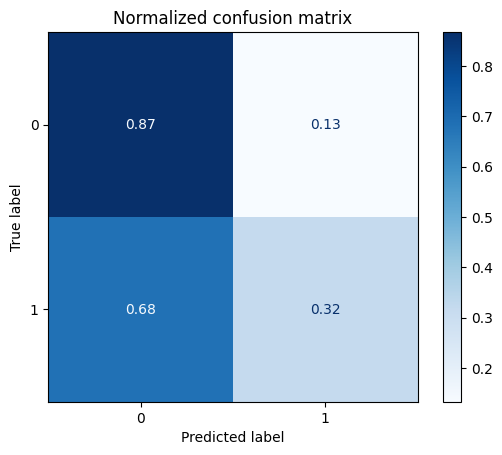

In [ ]:
# Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(best_rf_ling,X_test_ling,y_test_ling,display_labels=np.unique(y_test_ling),cmap=plt.cm.Blues,normalize="true")
disp.ax_.set_title("Normalized confusion matrix")
print(disp.confusion_matrix)
plt.show()

In [ ]:
y_roc = pd.DataFrame(y)
type(y_roc)

pandas.core.frame.DataFrame

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

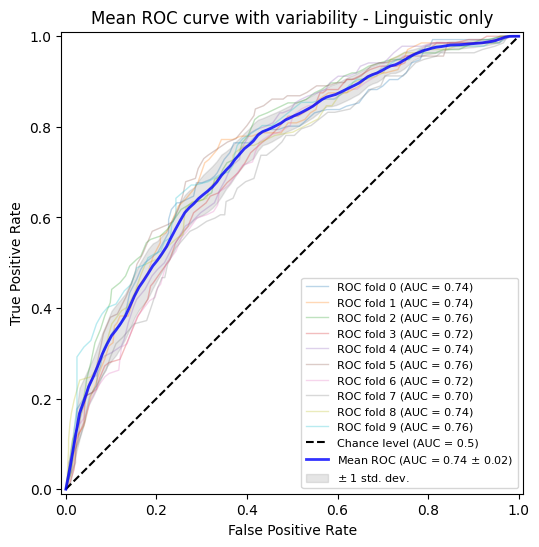

In [ ]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X_ling, y_roc)):
    best_rf_ling.fit(X_ling.iloc[train], y_roc.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        best_rf_ling,
        X_ling.iloc[test],
        y_roc.iloc[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability - Linguistic only",
)
ax.legend(loc="lower right", prop={'size': 8})
plt.show()


In [ ]:
# Save the best Random Forest model to a file
joblib.dump(best_rf_ling, 'best_rf_ling.pkl')

['best_rf_ling.pkl']

In [ ]:
# Load the saved model
best_rf_ling = joblib.load('best_rf_ling.pkl')
# Verify
print(best_rf_ling)

RandomForestClassifier(max_depth=15, max_features='log2',
                       min_samples_leaf=0.001, min_samples_split=0.005,
                       random_state=592)


## All Networks Data only

In [ ]:
seed = randint(10000)
# validation split
X_temp_nets_all, X_val_nets_all, y_temp_nets_all, y_val_nets_all = train_test_split(X_nets_all,y,train_size=0.9,random_state=seed,stratify=y)
# train test split
X_train_nets_all, X_test_nets_all, y_train_nets_all, y_test_nets_all = train_test_split(X_temp_nets_all,y_temp_nets_all,train_size=0.9,random_state=seed,stratify=y_temp_nets_all)

In [ ]:
# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=seed)

# Initialize RandomizedSearchCV
random_search_nets_all = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=200,   # Number of parameter settings to sample
    cv=5,        # Number of cross-validation folds - stratified by default
    verbose=2,   # Controls the verbosity
    random_state=seed,
    n_jobs=-1    # Use all available cores
)

# Fit RandomizedSearchCV
random_search_nets_all.fit(X_train_nets_all, y_train_nets_all)

# Get the best model
best_rf_nets_all = random_search_nets_all.best_estimator_


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


Get the mean and std from this - output the full list & save or note down

In [ ]:
# Access the cv_results_ dictionary
nets_all_rf_results = random_search_nets_all.cv_results_

# Extract the relevant parameters and scores
param_results = pd.DataFrame(nets_all_rf_results['params'])  # DataFrame of parameters
param_results['mean_test_score'] = nets_all_rf_results['mean_test_score']  # mean test scores for each set of parameters
param_results['std_test_score'] = nets_all_rf_results['std_test_score']   # std for 5 folds across each set of params

# Save to CSV
param_results.to_csv('nets_all_only_rf_results.csv', index=False)


In [ ]:
# Print the parameters of the best estimator
print("Best estimator parameters:")
print(random_search_nets_all.best_estimator_.get_params())

Best estimator parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.0015, 'min_samples_split': 0.005, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 125, 'n_jobs': None, 'oob_score': False, 'random_state': 8239, 'verbose': 0, 'warm_start': False}


In [ ]:
# Evaluate on training data
train_acc = best_rf_nets_all.score(X_train_nets_all, y_train_nets_all)
print(f"Train Accuracy: {train_acc:.4f}")

# Evaluate on test data
test_acc = best_rf_nets_all.score(X_test_nets_all, y_test_nets_all)
print(f"Test Accuracy: {test_acc:.4f}")

# Predict on test data
preds = best_rf_nets_all.predict(X_test_nets_all)
print(classification_report(y_test_nets_all, preds))


Train Accuracy: 0.7346
Test Accuracy: 0.7332
              precision    recall  f1-score   support

           0       0.76      0.90      0.83       293
           1       0.59      0.33      0.42       123

    accuracy                           0.73       416
   macro avg       0.67      0.61      0.62       416
weighted avg       0.71      0.73      0.71       416



[[0.90443686 0.09556314]
 [0.67479675 0.32520325]]


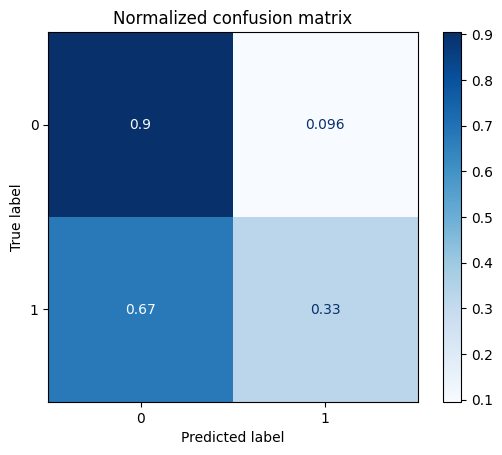

In [ ]:
# Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(best_rf_nets_all,X_test_nets_all,y_test_nets_all,display_labels=np.unique(y_test_nets_all),cmap=plt.cm.Blues,normalize="true")
disp.ax_.set_title("Normalized confusion matrix")
print(disp.confusion_matrix)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

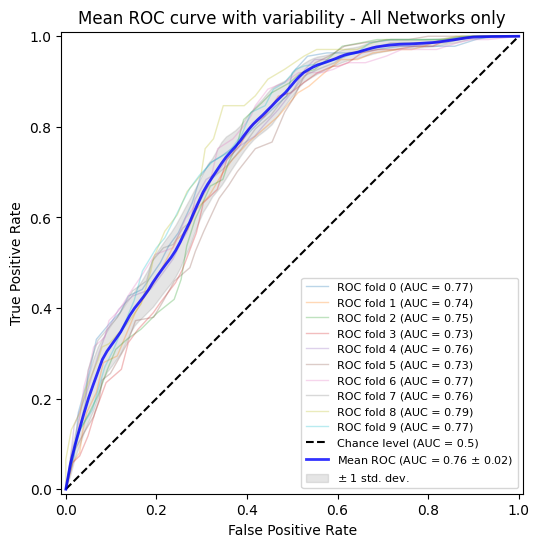

In [ ]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, shuffle = True)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X_nets_all, y_roc)):
    best_rf_nets_all.fit(X_nets_all.iloc[train], y_roc.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        best_rf_nets_all,
        X_nets_all.iloc[test],
        y_roc.iloc[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability - All Networks only",
)
ax.legend(loc="lower right", prop={'size': 8})
plt.show()


In [ ]:
# Save the best Random Forest model to a file
joblib.dump(best_rf_nets_all, 'best_rf_nets_all_only.pkl')

['best_rf_nets_all_only.pkl']

In [ ]:
# Load the saved model
best_rf_nets_all = joblib.load('best_rf_nets_all_only.pkl')
# Verify
print(best_rf_nets_all)

RandomForestClassifier(max_depth=15, max_features='log2',
                       min_samples_leaf=0.0015, min_samples_split=0.005,
                       n_estimators=125, random_state=8239)


## All Selected Networks Data

In [ ]:
seed = randint(10000)
# validation split
X_temp_nets_sel, X_val_nets_sel, y_temp_nets_sel, y_val_nets_sel = train_test_split(X_nets_sel,y,train_size=0.9,random_state=seed,stratify=y)
# train test split
X_train_nets_sel, X_test_nets_sel, y_train_nets_sel, y_test_nets_sel = train_test_split(X_temp_nets_sel,y_temp_nets_sel,train_size=0.9,random_state=seed,stratify=y_temp_nets_sel)

In [ ]:
# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=seed)

# Initialize RandomizedSearchCV
random_search_nets_sel = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=200,   # Number of parameter settings to sample
    cv=5,        # Number of cross-validation folds - stratified by default
    verbose=2,   # Controls the verbosity
    random_state=seed,
    n_jobs=-1    # Use all available cores
)

# Fit RandomizedSearchCV
random_search_nets_sel.fit(X_train_nets_sel, y_train_nets_sel)

# Get the best model
best_rf_nets_sel = random_search_nets_sel.best_estimator_


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


Get the mean and std from this - output the full list & save or note down

In [ ]:
# Access the cv_results_ dictionary
nets_sel_rf_results = random_search_nets_sel.cv_results_

# Extract the relevant parameters and scores
param_results = pd.DataFrame(nets_sel_rf_results['params'])  # DataFrame of parameters
param_results['mean_test_score'] = nets_sel_rf_results['mean_test_score']  # mean test scores for each set of parameters
param_results['std_test_score'] = nets_sel_rf_results['std_test_score']   # std for 5 folds across each set of params

# Save to CSV
param_results.to_csv('nets_sel_only_rf_results.csv', index=False)


In [ ]:
# Print the parameters of the best estimator
print("Best estimator parameters:")
print(random_search_nets_sel.best_estimator_.get_params())

Best estimator parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.001, 'min_samples_split': 0.005, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 150, 'n_jobs': None, 'oob_score': False, 'random_state': 7797, 'verbose': 0, 'warm_start': False}


In [ ]:
# Evaluate on training data
train_acc = best_rf_nets_sel.score(X_train_nets_sel, y_train_nets_sel)
print(f"Train Accuracy: {train_acc:.4f}")

# Evaluate on test data
test_acc = best_rf_nets_sel.score(X_test_nets_sel, y_test_nets_sel)
print(f"Test Accuracy: {test_acc:.4f}")

# Predict on test data
preds = best_rf_nets_sel.predict(X_test_nets_sel)
print(classification_report(y_test_nets_sel, preds))


Train Accuracy: 0.7349
Test Accuracy: 0.7308
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       293
           1       0.57      0.37      0.45       123

    accuracy                           0.73       416
   macro avg       0.67      0.63      0.64       416
weighted avg       0.71      0.73      0.71       416



[[0.88054608 0.11945392]
 [0.62601626 0.37398374]]


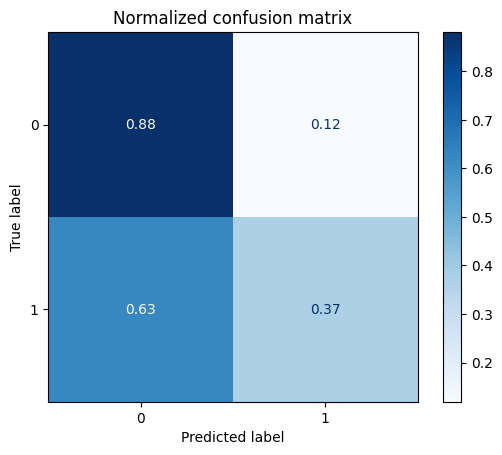

In [ ]:
# Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(best_rf_nets_sel,X_test_nets_sel,y_test_nets_sel,display_labels=np.unique(y_test_nets_sel),cmap=plt.cm.Blues,normalize="true")
disp.ax_.set_title("Normalized confusion matrix")
print(disp.confusion_matrix)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

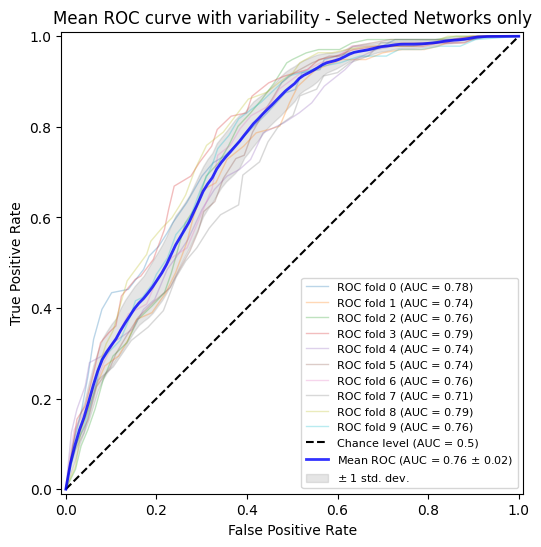

In [ ]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X_nets_sel, y_roc)):
    best_rf_nets_sel.fit(X_nets_sel.iloc[train], y_roc.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        best_rf_nets_sel,
        X_nets_sel.iloc[test],
        y_roc.iloc[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability - Selected Networks only",
)
ax.legend(loc="lower right", prop={'size': 8})
plt.show()


In [ ]:
# Save the best Random Forest model to a file
joblib.dump(best_rf_nets_sel, 'best_rf_nets_sel_only.pkl')

['best_rf_nets_sel_only.pkl']

In [ ]:
# Load the saved model
best_rf_nets_sel = joblib.load('best_rf_nets_sel_only.pkl')
# Verify
print(best_rf_nets_sel)

RandomForestClassifier(max_depth=20, min_samples_leaf=0.001,
                       min_samples_split=0.005, n_estimators=150,
                       random_state=7797)


## Clin + Ling

Validation set split - rename these to be unique val and test train sets by dataset

In [ ]:
seed = randint(10000)
# validation split
X_temp_clin_ling, X_val_clin_ling, y_temp_clin_ling, y_val_clin_ling = train_test_split(X_clin_ling,y,train_size=0.9,random_state=seed,stratify=y)
# train test split
X_train_clin_ling, X_test_clin_ling, y_train_clin_ling, y_test_clin_ling = train_test_split(X_temp_clin_ling,y_temp_clin_ling,train_size=0.9,random_state=seed,stratify=y_temp_clin_ling)

In [ ]:
# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=seed)

# Initialize RandomizedSearchCV
random_search_clin_ling = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=200,   # Number of parameter settings to sample
    cv=5,        # Number of cross-validation folds - stratified by default
    verbose=2,   # Controls the verbosity
    random_state=seed,
    n_jobs=-1    # Use all available cores
)

# Fit RandomizedSearchCV
random_search_clin_ling.fit(X_train_clin_ling, y_train_clin_ling)

# Get the best model
best_rf = random_search_clin_ling.best_estimator_


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


Get the mean and std from this - output the full list & save or note down

In [ ]:
# Access the cv_results_ dictionary
clin_ling_rf_results = random_search_clin_ling.cv_results_

# Extract the relevant parameters and scores
param_results = pd.DataFrame(clin_ling_rf_results['params'])  # DataFrame of parameters
param_results['mean_test_score'] = clin_ling_rf_results['mean_test_score']  # mean test scores for each set of parameters
param_results['std_test_score'] = clin_ling_rf_results['std_test_score']   # std for 5 folds across each set of params

# Save to CSV
param_results.to_csv('clin_ling_2_rf_results.csv', index=False)


In [ ]:
# Print the parameters of the best estimator
print("Best estimator parameters:")
print(random_search_clin_ling.best_estimator_.get_params())

Best estimator parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.001, 'min_samples_split': 0.0025, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 6639, 'verbose': 0, 'warm_start': False}


In [ ]:
best_rf_clin_ling = random_search_clin_ling.best_estimator_
# Evaluate on training data
train_acc = best_rf_clin_ling.score(X_train_clin_ling, y_train_clin_ling)
print(f"Train Accuracy: {train_acc:.4f}")

# Evaluate on test data
test_acc = best_rf_clin_ling.score(X_test_clin_ling, y_test_clin_ling)
print(f"Test Accuracy: {test_acc:.4f}")

# Predict on test data
preds = best_rf.predict(X_test_clin_ling)
print(classification_report(y_test_clin_ling, preds))


Train Accuracy: 0.8739
Test Accuracy: 0.8293
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       293
           1       0.78      0.59      0.67       123

    accuracy                           0.83       416
   macro avg       0.81      0.76      0.78       416
weighted avg       0.82      0.83      0.82       416



[[0.92832765 0.07167235]
 [0.40650407 0.59349593]]


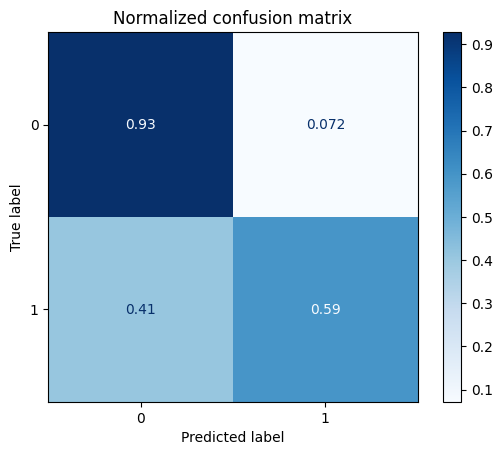

In [ ]:
# Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(best_rf_clin_ling,X_test_clin_ling,y_test_clin_ling,display_labels=np.unique(y_test_clin_ling),cmap=plt.cm.Blues,normalize="true")
disp.ax_.set_title("Normalized confusion matrix")
print(disp.confusion_matrix)
plt.show()

In [ ]:
y_roc = pd.DataFrame(y)
type(y_roc)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

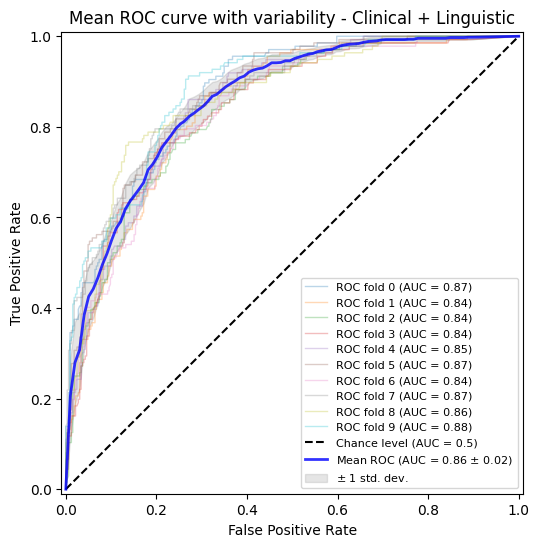

In [ ]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X_clin_ling, y_roc)):
    best_rf_clin_ling.fit(X_clin_ling.iloc[train], y_roc.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        best_rf_clin_ling,
        X_clin_ling.iloc[test],
        y_roc.iloc[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability - Clinical + Linguistic",
)
ax.legend(loc="lower right", prop={'size': 8})
plt.show()


In [ ]:
best_rf_clin_ling = random_search_clin_ling.best_estimator_

# Save the best Random Forest model to a file
joblib.dump(best_rf_clin_ling, 'best_rf_clin_ling_2.pkl')

['best_rf_clin_ling_2.pkl']

In [ ]:
# Load the saved model
best_rf_clin_ling = joblib.load('best_rf_clin_ling_2.pkl')
# Verify
print(best_rf_clin_ling)


RandomForestClassifier(max_depth=20, max_features='log2',
                       min_samples_leaf=0.001, min_samples_split=0.0025,
                       n_estimators=50, random_state=6639)


## Clin + Nets_sel

Validation set split - rename these to be unique val and test train sets by dataset

In [ ]:
seed = randint(10000)
# validation split
X_temp_clin_nets_sel, X_val_clin_nets_sel, y_temp_clin_nets_sel, y_val_clin_nets_sel = train_test_split(X_clin_nets_sel,y,train_size=0.9,random_state=seed,stratify=y)
# train test split
X_train_clin_nets_sel, X_test_clin_nets_sel, y_train_clin_nets_sel, y_test_clin_nets_sel = train_test_split(X_temp_clin_nets_sel,y_temp_clin_nets_sel,train_size=0.9,random_state=seed,stratify=y_temp_clin_nets_sel)

In [ ]:
# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=seed)

# Initialize RandomizedSearchCV
random_search_clin_nets_sel = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=200,   # Number of parameter settings to sample
    cv=5,        # Number of cross-validation folds - stratified by default
    verbose=2,   # Controls the verbosity
    random_state=seed,
    n_jobs=-1    # Use all available cores
)

# Fit RandomizedSearchCV
random_search_clin_nets_sel.fit(X_train_clin_nets_sel, y_train_clin_nets_sel)

# Get the best model
best_rf = random_search_clin_nets_sel.best_estimator_


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


Get the mean and std from this - output the full list & save or note down

In [ ]:
# Access the cv_results_ dictionary
clin_nets_sel_rf_results = random_search_clin_nets_sel.cv_results_

# Extract the relevant parameters and scores
param_results = pd.DataFrame(clin_nets_sel_rf_results['params'])  # DataFrame of parameters
param_results['mean_test_score'] = clin_nets_sel_rf_results['mean_test_score']  # mean test scores for each set of parameters
param_results['std_test_score'] = clin_nets_sel_rf_results['std_test_score']   # std for 5 folds across each set of params

# Save to CSV
param_results.to_csv('clin_nets_sel_2_rf_results.csv', index=False)


In [ ]:
# Print the parameters of the best estimator
print("Best estimator parameters:")
print(random_search_clin_nets_sel.best_estimator_.get_params())

Best estimator parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.002, 'min_samples_split': 0.005, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 125, 'n_jobs': None, 'oob_score': False, 'random_state': 445, 'verbose': 0, 'warm_start': False}


In [ ]:
best_rf_clin_nets_sel = random_search_clin_nets_sel.best_estimator_
# Evaluate on training data
train_acc = best_rf_clin_nets_sel.score(X_train_clin_nets_sel, y_train_clin_nets_sel)
print(f"Train Accuracy: {train_acc:.4f}")

# Evaluate on test data
test_acc = best_rf_clin_nets_sel.score(X_test_clin_nets_sel, y_test_clin_nets_sel)
print(f"Test Accuracy: {test_acc:.4f}")

# Predict on test data
preds = best_rf.predict(X_test_clin_nets_sel)
print(classification_report(y_test_clin_nets_sel, preds))


Train Accuracy: 0.7304
Test Accuracy: 0.7356
              precision    recall  f1-score   support

           0       0.75      0.93      0.83       293
           1       0.62      0.28      0.38       123

    accuracy                           0.74       416
   macro avg       0.69      0.60      0.61       416
weighted avg       0.71      0.74      0.70       416



[[0.92832765 0.07167235]
 [0.72357724 0.27642276]]


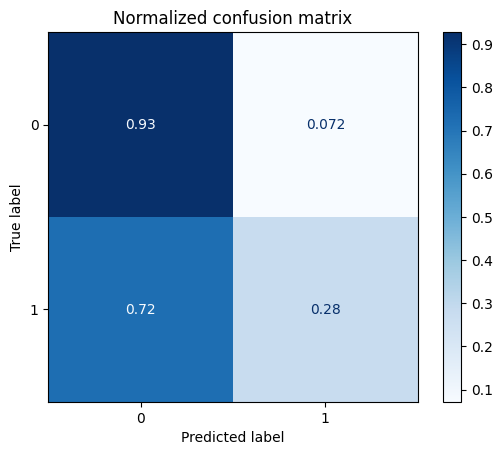

In [ ]:
# Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(best_rf_clin_nets_sel,X_test_clin_nets_sel,y_test_clin_nets_sel,display_labels=np.unique(y_test_clin_nets_sel),cmap=plt.cm.Blues,normalize="true")
disp.ax_.set_title("Normalized confusion matrix")
print(disp.confusion_matrix)
plt.show()

In [ ]:
y_roc = pd.DataFrame(y)
type(y_roc)

pandas.core.frame.DataFrame

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

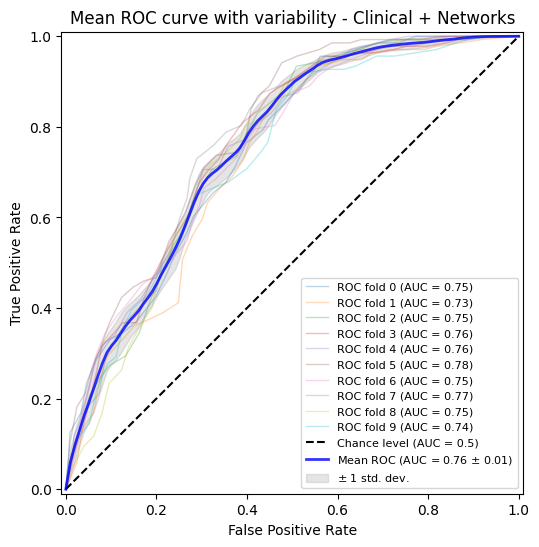

In [ ]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, shuffle = True)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X_clin_nets_sel, y_roc)):
    best_rf_clin_nets_sel.fit(X_clin_nets_sel.iloc[train], y_roc.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        best_rf_clin_nets_sel,
        X_clin_nets_sel.iloc[test],
        y_roc.iloc[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability - Clinical + Networks",
)
ax.legend(loc="lower right", prop={'size': 8})
plt.show()


In [ ]:
best_rf_clin_nets_sel = random_search_clin_nets_sel.best_estimator_

# Save the best Random Forest model to a file
joblib.dump(best_rf_clin_nets_sel, 'best_rf_clin_nets_sel_2.pkl')

['best_rf_clin_nets_sel_2.pkl']

In [ ]:
# Load the saved model
best_rf_clin_nets_sel = joblib.load('best_rf_clin_nets_sel_2.pkl')
# Verify
print(best_rf_clin_nets_sel)


RandomForestClassifier(max_depth=20, min_samples_leaf=0.002,
                       min_samples_split=0.005, n_estimators=125,
                       random_state=445)


## Ling + Nets_sel

In [ ]:
seed = randint(10000)
# validation split
X_temp_ling_nets_sel, X_val_ling_nets_sel, y_temp_ling_nets_sel, y_val_ling_nets_sel = train_test_split(X_ling_nets_sel,y,train_size=0.9,random_state=seed,stratify=y)
# train test split
X_train_ling_nets_sel, X_test_ling_nets_sel, y_train_ling_nets_sel, y_test_ling_nets_sel = train_test_split(X_temp_ling_nets_sel,y_temp_ling_nets_sel,train_size=0.9,random_state=seed,stratify=y_temp_ling_nets_sel)

In [ ]:
# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=seed)

# Initialize RandomizedSearchCV
random_search_ling_nets_sel = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=200,   # Number of parameter settings to sample
    cv=5,        # Number of cross-validation folds - stratified by default
    verbose=2,   # Controls the verbosity
    random_state=seed,
    n_jobs=-1    # Use all available cores
)

# Fit RandomizedSearchCV
random_search_ling_nets_sel.fit(X_train_ling_nets_sel, y_train_ling_nets_sel)

# Get the best model
best_rf_ling_nets_sel = random_search_ling_nets_sel.best_estimator_


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


Get the mean and std from this - output the full list & save or note down

In [ ]:
# Access the cv_results_ dictionary
ling_nets_sel_rf_results = random_search_ling_nets_sel.cv_results_

# Extract the relevant parameters and scores
param_results = pd.DataFrame(ling_nets_sel_rf_results['params'])  # DataFrame of parameters
param_results['mean_test_score'] = ling_nets_sel_rf_results['mean_test_score']  # mean test scores for each set of parameters
param_results['std_test_score'] = ling_nets_sel_rf_results['std_test_score']   # std for 5 folds across each set of params

# Save to CSV
param_results.to_csv('ling_nets_sel_2_rf_results.csv', index=False)


In [ ]:
# Print the parameters of the best estimator
print("Best estimator parameters:")
print(random_search_ling_nets_sel.best_estimator_.get_params())

Best estimator parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.001, 'min_samples_split': 0.005, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 7900, 'verbose': 0, 'warm_start': False}


In [ ]:
best_rf_ling_nets_sel = random_search_ling_nets_sel.best_estimator_
# Evaluate on training data
train_acc = best_rf_ling_nets_sel.score(X_train_ling_nets_sel, y_train_ling_nets_sel)
print(f"Train Accuracy: {train_acc:.4f}")

# Evaluate on test data
test_acc = best_rf_ling_nets_sel.score(X_test_ling_nets_sel, y_test_ling_nets_sel)
print(f"Test Accuracy: {test_acc:.4f}")

# Predict on test data
preds = best_rf_ling_nets_sel.predict(X_test_ling_nets_sel)
print(classification_report(y_test_ling_nets_sel, preds))


Train Accuracy: 0.8439
Test Accuracy: 0.7716
              precision    recall  f1-score   support

           0       0.80      0.89      0.85       293
           1       0.66      0.48      0.55       123

    accuracy                           0.77       416
   macro avg       0.73      0.69      0.70       416
weighted avg       0.76      0.77      0.76       416



[[0.89419795 0.10580205]
 [0.5203252  0.4796748 ]]


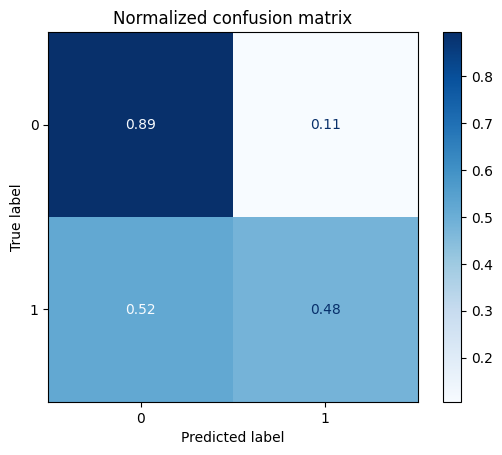

In [ ]:
# Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(best_rf_ling_nets_sel,X_test_ling_nets_sel,y_test_ling_nets_sel,display_labels=np.unique(y_test_ling_nets_sel),cmap=plt.cm.Blues,normalize="true")
disp.ax_.set_title("Normalized confusion matrix")
print(disp.confusion_matrix)
plt.show()

In [ ]:
y_roc = pd.DataFrame(y)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

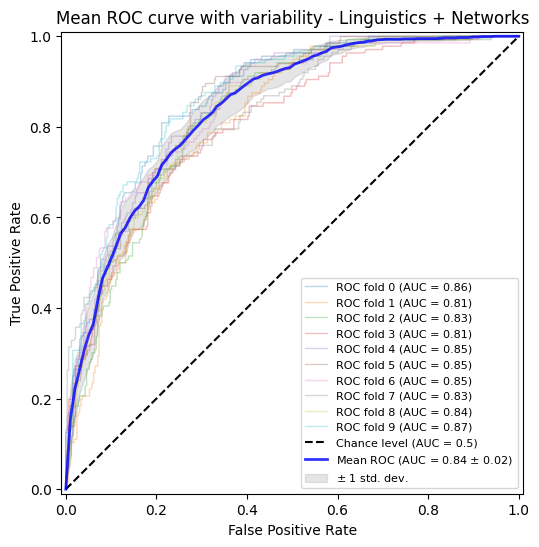

In [ ]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X_ling_nets_sel, y_roc)):
    best_rf_ling_nets_sel.fit(X_ling_nets_sel.iloc[train], y_roc.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        best_rf_ling_nets_sel,
        X_ling_nets_sel.iloc[test],
        y_roc.iloc[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability - Linguistics + Networks",
)
ax.legend(loc="lower right", prop={'size': 8})
plt.show()


In [ ]:
best_rf_ling_nets_sel = random_search_ling_nets_sel.best_estimator_

# Save the best Random Forest model to a file
joblib.dump(best_rf_ling_nets_sel, 'best_rf_ling_nets_sel_2.pkl')

['best_rf_ling_nets_sel_2.pkl']

In [ ]:
# Load the saved model
best_rf_ling_nets_sel = joblib.load('best_rf_ling_nets_sel_2.pkl')
# Verify
print(best_rf_ling_nets_sel)


RandomForestClassifier(max_depth=20, max_features='log2',
                       min_samples_leaf=0.001, min_samples_split=0.005,
                       random_state=7900)


# Best RF models for all data vs all selected data

## Clin + Ling + All Nets (All3)

In [ ]:
seed = randint(10000)
# validation split
X_temp_all3, X_val_all3, y_temp_all3, y_val_all3 = train_test_split(X_all3,y,train_size=0.9,random_state=seed,stratify=y)
# train test split
X_train_all3, X_test_all3, y_train_all3, y_test_all3 = train_test_split(X_temp_all3,y_temp_all3,train_size=0.9,random_state=seed,stratify=y_temp_all3)

In [ ]:
# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=seed)

# Initialize RandomizedSearchCV
random_search_all3 = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=200,   # Number of parameter settings to sample
    cv=5,        # Number of cross-validation folds - stratified by default
    verbose=2,   # Controls the verbosity
    random_state=seed,
    n_jobs=-1    # Use all available cores
)

# Fit RandomizedSearchCV
random_search_all3.fit(X_train_all3, y_train_all3)

# Get the best model
best_rf_all3 = random_search_all3.best_estimator_


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


Get the mean and std from this - output the full list & save or note down

In [ ]:
# Access the cv_results_ dictionary
all3_rf_results = random_search_all3.cv_results_

# Extract the relevant parameters and scores
param_results = pd.DataFrame(all3_rf_results['params'])  # DataFrame of parameters
param_results['mean_test_score'] = all3_rf_results['mean_test_score']  # mean test scores for each set of parameters
param_results['std_test_score'] = all3_rf_results['std_test_score']   # std for 5 folds across each set of params

# Save to CSV
param_results.to_csv('all3_rf_results.csv', index=False)


In [ ]:
# Print the parameters of the best estimator
print("Best estimator parameters:")
print(random_search_all3.best_estimator_.get_params())

Best estimator parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.001, 'min_samples_split': 0.0025, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 3348, 'verbose': 0, 'warm_start': False}


In [ ]:
# Evaluate on training data
train_acc = best_rf_all3.score(X_train_all3, y_train_all3)
print(f"Train Accuracy: {train_acc:.4f}")

# Evaluate on test data
test_acc = best_rf_all3.score(X_test_all3, y_test_all3)
print(f"Test Accuracy: {test_acc:.4f}")

# Predict on test data
preds = best_rf_all3.predict(X_test_all3)
print(classification_report(y_test_all3, preds))


Train Accuracy: 0.8610
Test Accuracy: 0.7885
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       293
           1       0.68      0.53      0.60       123

    accuracy                           0.79       416
   macro avg       0.75      0.71      0.73       416
weighted avg       0.78      0.79      0.78       416



[[0.89761092 0.10238908]
 [0.47154472 0.52845528]]


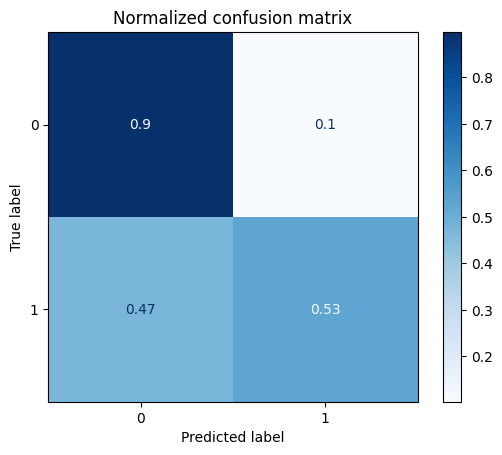

In [ ]:
# Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(best_rf_all3,X_test_all3,y_test_all3,display_labels=np.unique(y_test_all3),cmap=plt.cm.Blues,normalize="true")
disp.ax_.set_title("Normalized confusion matrix")
print(disp.confusion_matrix)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

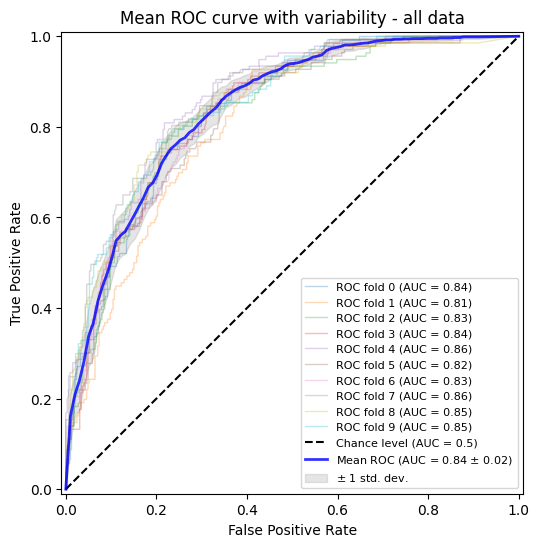

In [ ]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X_all3, y_roc)):
    best_rf_all3.fit(X_all3.iloc[train], y_roc.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        best_rf_all3,
        X_all3.iloc[test],
        y_roc.iloc[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability - all data",
)
ax.legend(loc="lower right", prop={'size': 8})
plt.show()


In [ ]:
# Save the best Random Forest model to a file
joblib.dump(best_rf_all3, 'best_rf_all3.pkl')

['best_rf_all3.pkl']

In [ ]:
# Load the saved model
best_rf_all3 = joblib.load('best_rf_all3.pkl')
# Verify
print(best_rf_all3)

RandomForestClassifier(max_depth=15, min_samples_leaf=0.001,
                       min_samples_split=0.0025, n_estimators=50,
                       random_state=3348)


## Clin + Ling + Sel Nets (All3_Sel)

In [ ]:
seed = randint(10000)
# validation split
X_temp_all3_sel, X_val_all3_sel, y_temp_all3_sel, y_val_all3_sel = train_test_split(X_all3_sel,y,train_size=0.9,random_state=seed,stratify=y)
# train test split
X_train_all3_sel, X_test_all3_sel, y_train_all3_sel, y_test_all3_sel = train_test_split(X_temp_all3_sel,y_temp_all3_sel,train_size=0.9,random_state=seed,stratify=y_temp_all3_sel)

In [ ]:
# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=seed)

# Initialize RandomizedSearchCV
random_search_all3_sel = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=200,   # Number of parameter settings to sample
    cv=5,        # Number of cross-validation folds - stratified by default
    verbose=2,   # Controls the verbosity
    random_state=seed,
    n_jobs=-1    # Use all available cores
)

# Fit RandomizedSearchCV
random_search_all3_sel.fit(X_train_all3_sel, y_train_all3_sel)

# Get the best model
best_rf_all3_sel = random_search_all3_sel.best_estimator_


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


Get the mean and std from this - output the full list & save or note down

In [ ]:
# Access the cv_results_ dictionary
all3_sel_rf_results = random_search_all3_sel.cv_results_

# Extract the relevant parameters and scores
param_results = pd.DataFrame(all3_sel_rf_results['params'])  # DataFrame of parameters
param_results['mean_test_score'] = all3_sel_rf_results['mean_test_score']  # mean test scores for each set of parameters
param_results['std_test_score'] = all3_sel_rf_results['std_test_score']   # std for 5 folds across each set of params

# Save to CSV
param_results.to_csv('all3_sel_only_rf_results.csv', index=False)


In [ ]:
# Print the parameters of the best estimator
print("Best estimator parameters:")
print(random_search_all3_sel.best_estimator_.get_params())

Best estimator parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.0015, 'min_samples_split': 0.0025, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 7016, 'verbose': 0, 'warm_start': False}


In [ ]:
# Evaluate on training data
train_acc = best_rf_all3_sel.score(X_train_all3_sel, y_train_all3_sel)
print(f"Train Accuracy: {train_acc:.4f}")

# Evaluate on test data
test_acc = best_rf_all3_sel.score(X_test_all3_sel, y_test_all3_sel)
print(f"Test Accuracy: {test_acc:.4f}")

# Predict on test data
preds = best_rf_all3_sel.predict(X_test_all3_sel)
print(classification_report(y_test_all3_sel, preds))


Train Accuracy: 0.8413
Test Accuracy: 0.8005
              precision    recall  f1-score   support

           0       0.82      0.92      0.87       293
           1       0.73      0.52      0.61       123

    accuracy                           0.80       416
   macro avg       0.77      0.72      0.74       416
weighted avg       0.79      0.80      0.79       416



[[0.91808874 0.08191126]
 [0.4796748  0.5203252 ]]


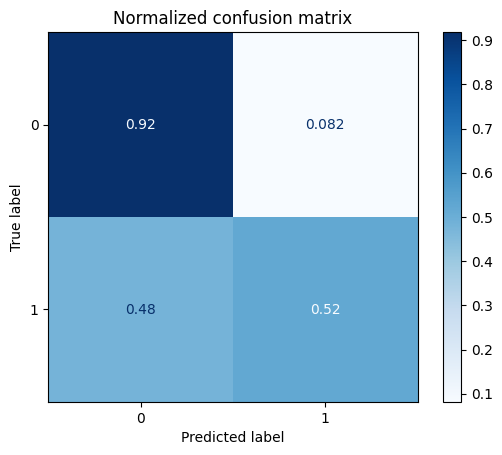

In [ ]:
# Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(best_rf_all3_sel,X_test_all3_sel,y_test_all3_sel,display_labels=np.unique(y_test_all3_sel),cmap=plt.cm.Blues,normalize="true")
disp.ax_.set_title("Normalized confusion matrix")
print(disp.confusion_matrix)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

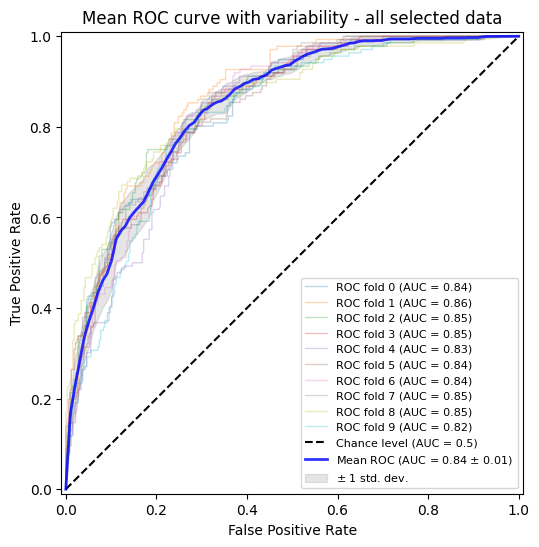

In [ ]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X_all3_sel, y_roc)):
    best_rf_all3_sel.fit(X_all3_sel.iloc[train], y_roc.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        best_rf_all3_sel,
        X_all3_sel.iloc[test],
        y_roc.iloc[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability - all selected data",
)
ax.legend(loc="lower right", prop={'size': 8})
plt.show()


In [ ]:
# Save the best Random Forest model to a file
joblib.dump(best_rf_all3_sel, 'best_rf_all3_sel.pkl')

['best_rf_all3_sel.pkl']

In [ ]:
# Load the saved model
best_rf_all3_sel = joblib.load('best_rf_all3_sel.pkl')
# Verify
print(best_rf_all3_sel)

RandomForestClassifier(max_depth=15, min_samples_leaf=0.0015,
                       min_samples_split=0.0025, random_state=7016)


# Dataset models Comparison figures

To Do: set this

https://seaborn.pydata.org/tutorial/color_palettes.html

In [ ]:
'''
sns.set_style("white")
sns.set_palette("Paired")
'''

## ROC
To Do: plot the ROC curves fold-wise. Add baseline


In [ ]:
clin_disp = []

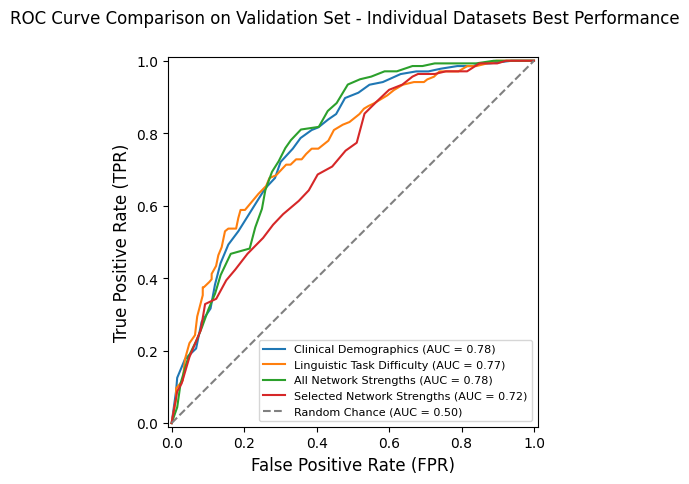

In [ ]:
# Generate ROC curve displays for each best model single datasets
clin_disp = RocCurveDisplay.from_estimator(best_rf_clin, X_val_clin, y_val_clin)
ling_disp = RocCurveDisplay.from_estimator(best_rf_ling, X_val_ling, y_val_ling, ax=clin_disp.ax_)
nets_all_disp = RocCurveDisplay.from_estimator(best_rf_nets_all, X_val_nets_all, y_val_nets_all, ax=clin_disp.ax_)
nets_sel_disp = RocCurveDisplay.from_estimator(best_rf_nets_sel, X_val_nets_sel, y_val_nets_sel, ax=clin_disp.ax_)

# Add a dashed line for random chance (Null Model)
clin_disp.ax_.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Chance')

# Create custom legend handles
handles, labels = clin_disp.ax_.get_legend_handles_labels()

# Extract AUC from the RocCurveDisplay objects
auc_clin = clin_disp.roc_auc
auc_ling = ling_disp.roc_auc
auc_nets_all = nets_all_disp.roc_auc
auc_nets_sel = nets_sel_disp.roc_auc

# Add the custom legend labels for each curve, including AUC values
labels = [
    f'Clinical Demographics (AUC = {auc_clin:.2f})',
    f'Linguistic Task Difficulty (AUC = {auc_ling:.2f})',
    f'All Network Strengths (AUC = {auc_nets_all:.2f})',
    f'Selected Network Strengths (AUC = {auc_nets_sel:.2f})',
    'Random Chance (AUC = 0.50)'
]
# Add the combined legend to the plot
clin_disp.ax_.legend(handles, labels, loc='lower right', prop={'size': 8})

# Change the axis labels
clin_disp.ax_.set_xlabel('False Positive Rate (FPR)', fontsize=12)  # Custom x-axis label
clin_disp.ax_.set_ylabel('True Positive Rate (TPR)', fontsize=12)  # Custom y-axis label

# Add title and other formatting
clin_disp.figure_.suptitle("ROC Curve Comparison on Validation Set - Individual Datasets Best Performance")

# Show the plot
plt.show()



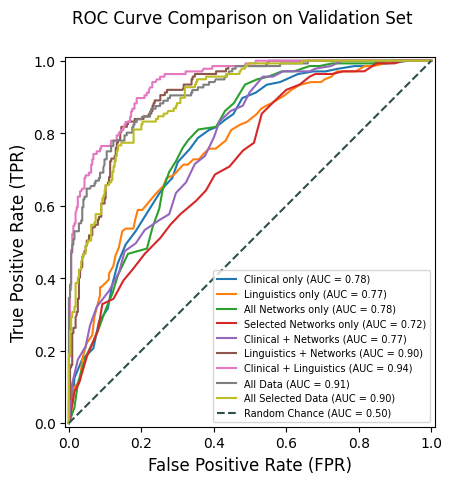

In [ ]:
# Generate ROC curve displays for each best model single datasets
clin_disp = RocCurveDisplay.from_estimator(best_rf_clin, X_val_clin, y_val_clin)
ling_disp = RocCurveDisplay.from_estimator(best_rf_ling, X_val_ling, y_val_ling, ax=clin_disp.ax_)
nets_all_disp = RocCurveDisplay.from_estimator(best_rf_nets_all, X_val_nets_all, y_val_nets_all, ax=clin_disp.ax_)
nets_sel_disp = RocCurveDisplay.from_estimator(best_rf_nets_sel, X_val_nets_sel, y_val_nets_sel, ax=clin_disp.ax_)

clin_nets_sel_disp = RocCurveDisplay.from_estimator(best_rf_clin_nets_sel, X_val_clin_nets_sel, y_val_clin_nets_sel, ax=clin_disp.ax_)
ling_nets_sel_disp = RocCurveDisplay.from_estimator(best_rf_ling_nets_sel, X_val_ling_nets_sel, y_val_ling_nets_sel, ax=clin_disp.ax_)
clin_ling_disp = RocCurveDisplay.from_estimator(best_rf_clin_ling, X_val_clin_ling, y_val_clin_ling, ax=clin_disp.ax_)

all3_disp = RocCurveDisplay.from_estimator(best_rf_all3, X_val_all3, y_val_all3, ax=clin_disp.ax_)
all3_sel_disp = RocCurveDisplay.from_estimator(best_rf_all3_sel, X_val_all3_sel, y_val_all3_sel, ax=clin_disp.ax_)


# Add a dashed line for random chance (Null Model)
clin_disp.ax_.plot([0, 1], [0, 1], linestyle='--', color='darkslategray', label='Random Chance')

# Create custom legend handles
handles, labels = clin_disp.ax_.get_legend_handles_labels()

# Extract AUC from the RocCurveDisplay objects
auc_clin = clin_disp.roc_auc
auc_ling = ling_disp.roc_auc
auc_nets_all = nets_all_disp.roc_auc
auc_nets_sel = nets_sel_disp.roc_auc

auc_clin_nets_sel = clin_nets_sel_disp.roc_auc
auc_ling_nets_sel = ling_nets_sel_disp.roc_auc
auc_clin_ling = clin_ling_disp.roc_auc

auc_all3 = all3_disp.roc_auc
auc_all3_sel = all3_sel_disp.roc_auc


# Add the custom legend labels for each curve, including AUC values
labels = [
    f'Clinical only (AUC = {auc_clin:.2f})',
    f'Linguistics only (AUC = {auc_ling:.2f})',
    f'All Networks only (AUC = {auc_nets_all:.2f})',
    f'Selected Networks only (AUC = {auc_nets_sel:.2f})',
    f'Clinical + Networks (AUC = {auc_clin_nets_sel:.2f})',
    f'Linguistics + Networks (AUC = {auc_ling_nets_sel:.2f})',
    f'Clinical + Linguistics (AUC = {auc_clin_ling:.2f})',
    f'All Data (AUC = {auc_all3:.2f})',
    f'All Selected Data (AUC = {auc_all3_sel:.2f})',
    'Random Chance (AUC = 0.50)'
]
# Add the combined legend to the plot
clin_disp.ax_.legend(handles, labels, loc='lower right', prop={'size': 7})

# Change the axis labels
clin_disp.ax_.set_xlabel('False Positive Rate (FPR)', fontsize=12)  # Custom x-axis label
clin_disp.ax_.set_ylabel('True Positive Rate (TPR)', fontsize=12)  # Custom y-axis label

# Add title and other formatting
clin_disp.figure_.suptitle("ROC Curve Comparison on Validation Set")

# Show the plot
plt.show()



#Learning Curve

In [ ]:
# Plotting the learning curve with stratified cross-validation
scorer = make_scorer(f1_score, pos_label=0)

learning_curve_display = LearningCurveDisplay.from_estimator(
    best_rf_clin_ling, X_clin_ling, y, scoring=scorer,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),  # Stratified cross-validation
    n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), return_times=False)

# Plot the learning curve
learning_curve_display.plot(xlabel='Training Set Size', ylabel='F1 score', title=f'Learning Curve for {best_rf_clin_ling}')

# Add a legend to the plot
plt.legend(title='Score Type', loc='best')

# Show the plot
plt.tight_layout()
plt.show()

# Extract the learning curve values
train_sizes = learning_curve_display.train_sizes_
train_scores = learning_curve_display.train_scores_
test_scores = learning_curve_display.test_scores_

# Reshape the data into a format suitable for saving, including fold values
all_results = []

for i, train_size in enumerate(train_sizes):
    for fold in range(train_scores.shape[1]):  # Iterate through each fold
        all_results.append({
            'train_size': train_size,
            'fold': fold + 1,  # Adding 1 to make fold numbering start at 1
            'train_score': train_scores[i, fold],
            'test_score': test_scores[i, fold],
        })

# Convert to a DataFrame
learning_curve_results = pd.DataFrame(all_results)

# Save the results to a CSV file
learning_curve_results.to_csv('learning_curve_clin_ling.csv', index=False)

# Save the X and y datasets

In [ ]:
pd.DataFrame(X_clin).to_excel('X_clin.xlsx', index=False)
pd.DataFrame(X_ling).to_excel('X_ling.xlsx', index=False)
pd.DataFrame(X_nets_all).to_excel('X_nets_all.xlsx', index=False)
pd.DataFrame(X_nets_sel).to_excel('X_nets_sel.xlsx', index=False)
pd.DataFrame(X_clin_ling).to_excel('X_clin_ling.xlsx', index=False)
pd.DataFrame(X_clin_nets_sel).to_excel('X_clin_nets_sel.xlsx', index=False)
pd.DataFrame(X_ling_nets_sel).to_excel('X_ling_nets_sel.xlsx', index=False)
pd.DataFrame(X_all3_sel).to_excel('X_all3_sel.xlsx', index=False)
pd.DataFrame(X_all3).to_excel('X_all3.xlsx', index=False)

pd.DataFrame(y).to_excel('y.xlsx', index=False)

In [ ]:
# code for loading in
y = pd.read_excel('y.xlsx')
X_clin = pd.read_excel('X_clin.xlsx')
X_ling = pd.read_excel('X_ling.xlsx')
X_nets_all = pd.read_excel('X_nets_all.xlsx')
X_nets_sel = pd.read_excel('X_nets_sel.xlsx')
X_clin_ling = pd.read_excel('X_clin_ling.xlsx')
X_clin_nets_sel = pd.read_excel('X_clin_nets_sel.xlsx')
X_ling_nets_sel = pd.read_excel('X_ling_nets_sel.xlsx')
X_all3_sel = pd.read_excel('X_all3_sel.xlsx')
X_all3 = pd.read_excel('X_all3.xlsx')


# Bootstrapping & figures

In [ ]:
# Function to generate bootstrapped performance metrics
def evaluate_classifier(classifier, X, y, n_partitions):
    results = []

    for i in range(n_partitions):
        # Split the data into training and testing sets for each partition
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify = y)

        # Train the classifier on the training set
        classifier.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = classifier.predict(X_test)

        # Calculate evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='binary', pos_label=0)
        auc = roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1])
        precision = precision_score(y_test, y_pred, pos_label=0)  # Precision for category 0
        recall = recall_score(y_test, y_pred, pos_label=0)  # Recall for category 0

        # Append results for this partition
        results.append({
            'partition': i + 1,
            'accuracy': accuracy,
            'f1_score': f1,
            'auc': auc,
            'precision_category_0': precision,
            'recall_category_0': recall
        })

    # Convert results into a DataFrame and return
    return pd.DataFrame(results)


In [ ]:
# Evaluate each classifier and store the results
n_partitions = 500

bootstrap_clin = evaluate_classifier(best_rf_clin, X_clin, y, n_partitions)
bootstrap_ling = evaluate_classifier(best_rf_ling, X_ling, y, n_partitions)
bootstrap_nets_all = evaluate_classifier(best_rf_nets_all, X_nets_all, y, n_partitions)
bootstrap_nets_sel = evaluate_classifier(best_rf_nets_sel, X_nets_sel, y, n_partitions)
bootstrap_clin_nets_sel = evaluate_classifier(best_rf_clin_nets_sel, X_clin_nets_sel, y, n_partitions)
bootstrap_ling_nets_sel = evaluate_classifier(best_rf_ling_nets_sel, X_ling_nets_sel, y, n_partitions)
bootstrap_clin_ling = evaluate_classifier(best_rf_clin_ling, X_clin_ling, y, n_partitions)
bootstrap_all3 = evaluate_classifier(best_rf_all3, X_all3, y, n_partitions)
bootstrap_all3_sel = evaluate_classifier(best_rf_all3_sel, X_all3_sel, y, n_partitions)


In [ ]:
bootstrap_clin.head()

,partition,accuracy,f1_score,auc,precision_category_0,recall_category_0
0,1,0.723665,0.823095,0.758994,0.750000,0.911975
1,2,0.722944,0.825137,0.760603,0.742623,0.928279
2,3,0.731602,0.827937,0.749449,0.755274,0.916070
3,4,0.730159,0.829845,0.748289,0.746929,0.933470
4,5,0.723665,0.824070,0.741703,0.747500,0.918117


After all the results are ready, make the figure

In [ ]:
# tabulate all into one df
classifier_names = [
    'best_rf_clin',
    'best_rf_ling',
    'best_rf_nets_all',
    'best_rf_nets_sel',
    'best_rf_clin_nets_sel',
    'best_rf_ling_nets_sel',
    'best_rf_clin_ling',
    'best_rf_all3',
    'best_rf_all3_sel',
]

# List of manually defined bootstrap results variables
bootstrap_df_names = [
    bootstrap_clin,
    bootstrap_ling,
    bootstrap_nets_all,
    bootstrap_nets_sel,
    bootstrap_clin_nets_sel,
    bootstrap_ling_nets_sel,
    bootstrap_clin_ling,
    bootstrap_all3,
    bootstrap_all3_sel,
]

metrics = ['accuracy', 'f1_score', 'auc', 'precision_category_0', 'recall_category_0']

all_results = [] # list to store all results in long format

# Iterate through the manually defined list of bootstrap results
for i, (df, clf) in enumerate(zip(bootstrap_df_names, classifier_names)):
    # Reshape the DataFrame to long format for easy plotting
    for metric in metrics:
        if metric in df.columns:  # Check if the metric is available in the DataFrame
            metric_data = df[metric]
            all_results.append(pd.DataFrame({
                'classifier': [clf] * len(metric_data),
                'metric': [metric] * len(metric_data),
                'value': metric_data
            }))


# Concatenate all the individual DataFrames into one
df_all_results = pd.concat(all_results, ignore_index=True)


In [ ]:
df_all_results.head()

,classifier,metric,value
0,best_rf_clin,accuracy,0.723665
1,best_rf_clin,accuracy,0.722944
2,best_rf_clin,accuracy,0.731602
3,best_rf_clin,accuracy,0.730159
4,best_rf_clin,accuracy,0.723665


In [ ]:
# Save the df_all_results DataFrame to a CSV file
df_all_results.to_excel('bootstrapped_clf_all_results.xlsx', index=False)

In [ ]:
# Save in wide format
for df, classifier in zip(bootstrap_df_names, classifier_names):
    df['classifier'] = classifier

# Concatenate all dataframes in the list vertically (adding rows)
final_df = pd.concat(bootstrap_df_names, ignore_index=True)

final_df.tail()

,partition,accuracy,f1_score,auc,precision_category_0,recall_category_0,classifier
4495,496,0.785714,0.851722,0.854362,0.830574,0.873975,best_rf_all3_sel
4496,497,0.778499,0.846577,0.838261,0.826341,0.867828,best_rf_all3_sel
4497,498,0.796537,0.863372,0.861738,0.819687,0.911975,best_rf_all3_sel
4498,499,0.781385,0.851689,0.830851,0.815370,0.891393,best_rf_all3_sel
4499,500,0.786436,0.855891,0.843929,0.815399,0.900615,best_rf_all3_sel


In [ ]:
final_df.to_excel('bootstrapped_clf_clin_ling_wideformat_all_results.xlsx', index=False)

<ipython-input-88-7d0091b09c7b>:8: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='metric', y='value', hue='classifier', data=df_all_results,


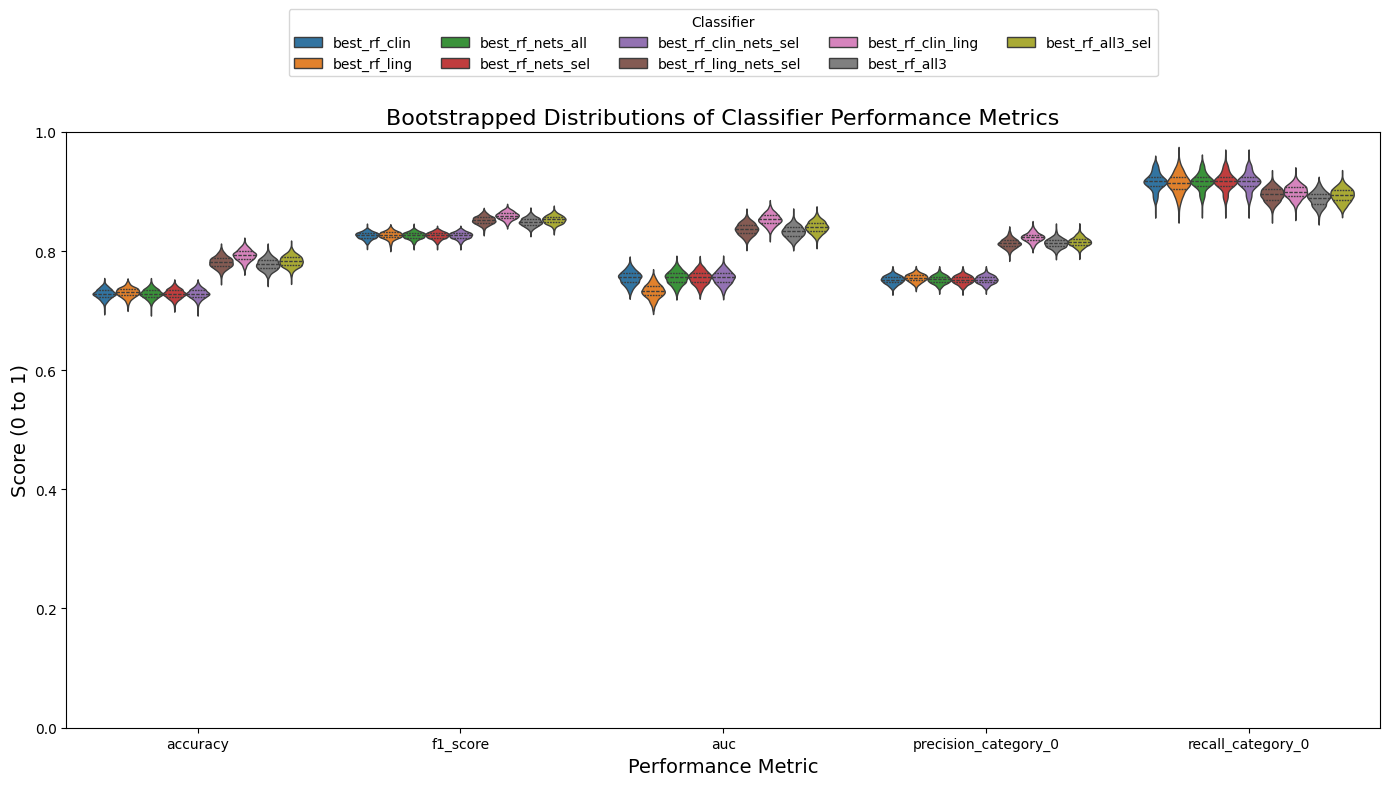

In [ ]:
# Plotting
plt.figure(figsize=(14, 8))

# Set the color palette for the classifiers using tab10 colors
sns.set_palette("tab10")

# Create the violin plot
sns.violinplot(x='metric', y='value', hue='classifier', data=df_all_results,
               split=False, inner='quart', linewidth=1, scale='width')

# Adjust y-axis to be from 0 to 1 for all metrics
plt.ylim(0, 1)

# Add a common title and axis labels
plt.title('Bootstrapped Distributions of Classifier Performance Metrics', fontsize=16)
plt.xlabel('Performance Metric', fontsize=14)
plt.ylabel('Score (0 to 1)', fontsize=14)

# Add a legend at the top
plt.legend(title='Classifier', bbox_to_anchor=(0.5, 1.15), loc='center', ncol=5)

# Show the plot
plt.tight_layout()
plt.show()

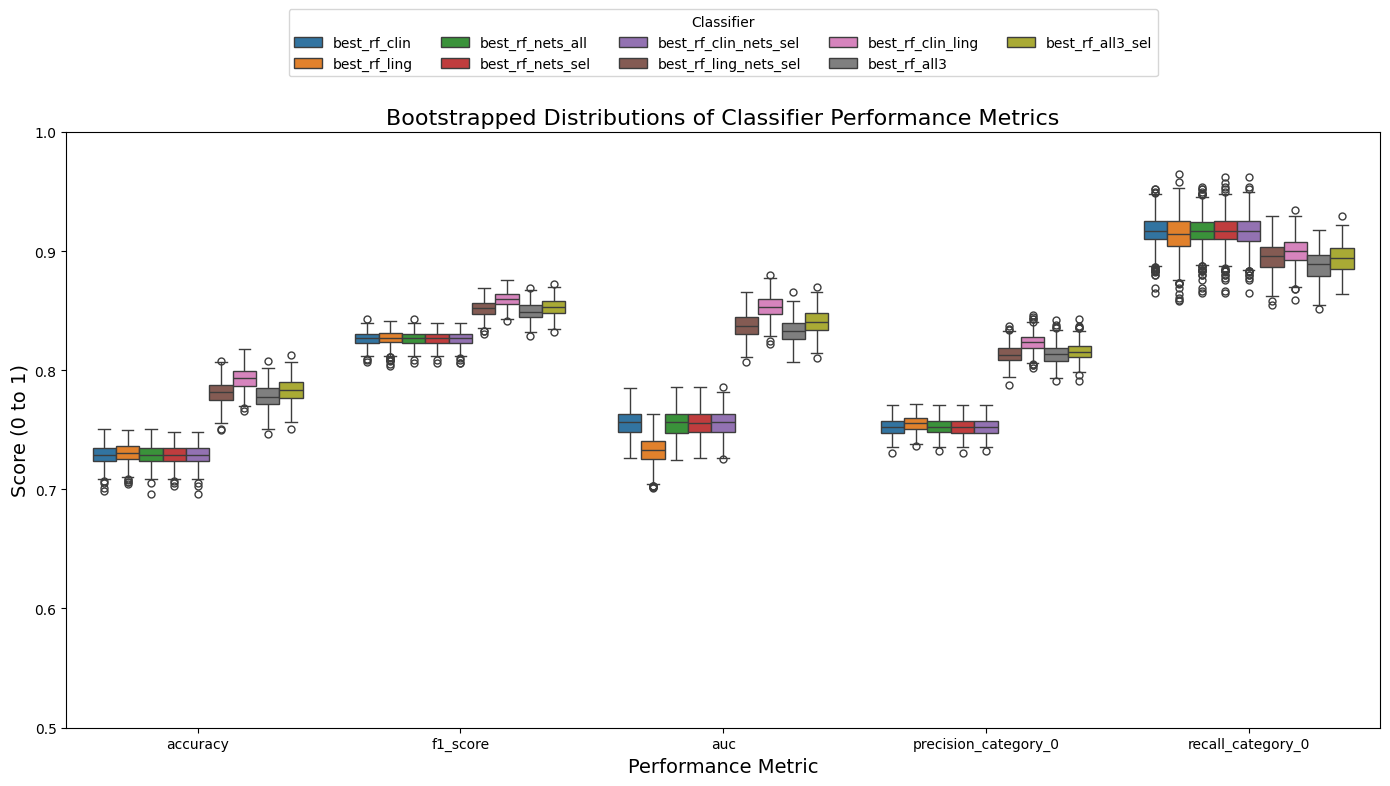

In [ ]:
# Plotting - alt figure boxplot
plt.figure(figsize=(14, 8))

# Set the color palette for the classifiers using tab10 colors
sns.set_palette("tab10")

# Create the box plot (instead of violin plot)
sns.boxplot(x='metric', y='value', hue='classifier', data=df_all_results,
            linewidth=1, fliersize=5)

# Adjust y-axis to be from 0 to 1 for all metrics
plt.ylim(0.5, 1)

# Add a common title and axis labels
plt.title('Bootstrapped Distributions of Classifier Performance Metrics', fontsize=16)
plt.xlabel('Performance Metric', fontsize=14)
plt.ylabel('Score (0 to 1)', fontsize=14)

# Add a legend at the top
plt.legend(title='Classifier', bbox_to_anchor=(0.5, 1.15), loc='center', ncol=5)

# Show the plot
plt.tight_layout()
plt.show()


<ipython-input-108-67053a0fb281>:8: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='metric', y='value', hue='classifier', data=df_all_results,


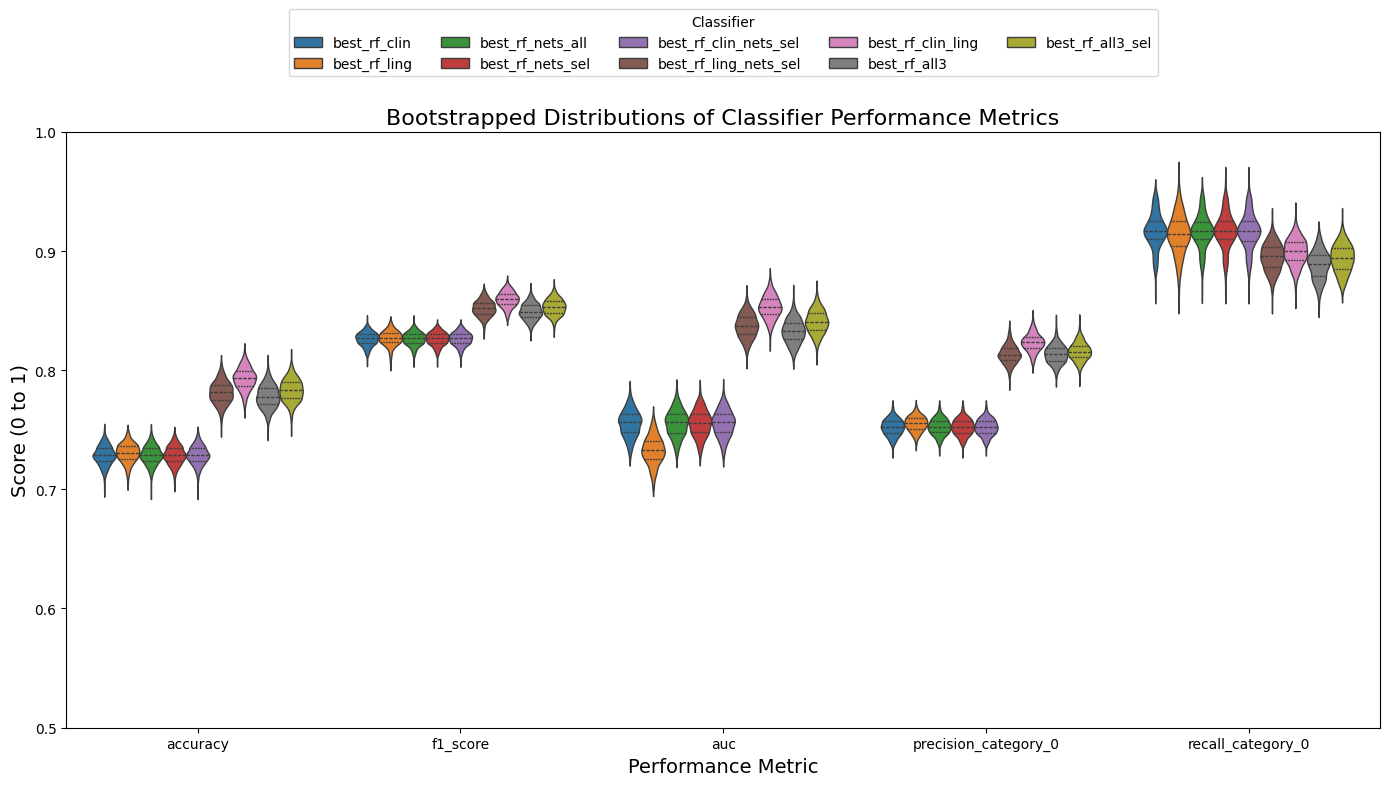

In [ ]:
# Plotting
plt.figure(figsize=(14, 8))

# Set the color palette for the classifiers using tab10 colors
sns.set_palette("tab10")

# Create the violin plot
sns.violinplot(x='metric', y='value', hue='classifier', data=df_all_results,
               split=False, inner='quart', linewidth=1, scale='width')

# Adjust y-axis to be from 0 to 1 for all metrics
plt.ylim(0.5, 1)

# Add a common title and axis labels
plt.title('Bootstrapped Distributions of Classifier Performance Metrics', fontsize=16)
plt.xlabel('Performance Metric', fontsize=14)
plt.ylabel('Score (0 to 1)', fontsize=14)

# Add a legend at the top
plt.legend(title='Classifier', bbox_to_anchor=(0.5, 1.15), loc='center', ncol=5)

# Show the plot
plt.tight_layout()
plt.show()